# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [ ]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label




In [ ]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),   # Flip the image horizontally
            A.VerticalFlip(p=0.5),     # Flip the image vertically
            #A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast (shape-preserving)
            A.RandomResizedCrop(height=64, width=128, scale=(0.8, 1.0), ratio=(1.0, 1.0), p=0.5),  # Zoom effect
            A.RandomCrop(height=64, width=128, p=0.5),  # Random crop
            #A.HueSaturationValue(p=0.2),  # Modify hue, saturation, and value (shape-preserving)
            #A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Add Gaussian noise (shape-preserving)
            A.Blur(blur_limit=3, p=0.2),  # Apply blur (shape-preserving)
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...
WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


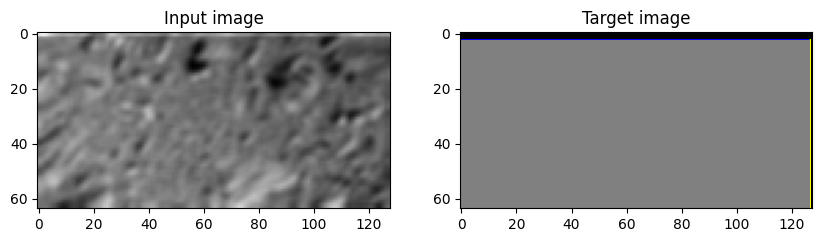

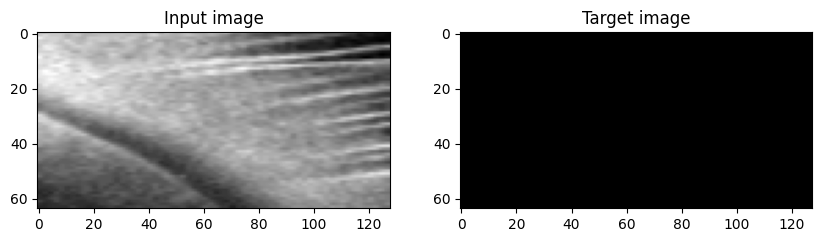

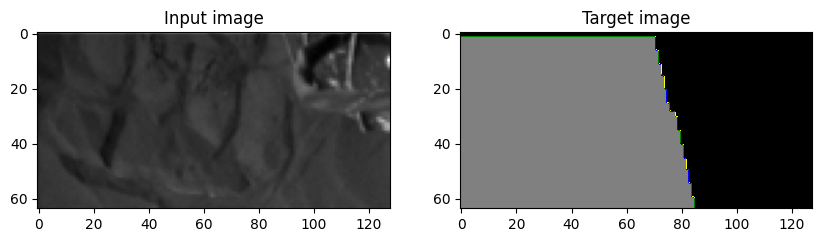

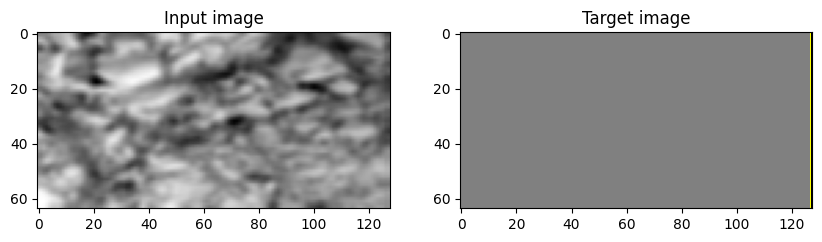

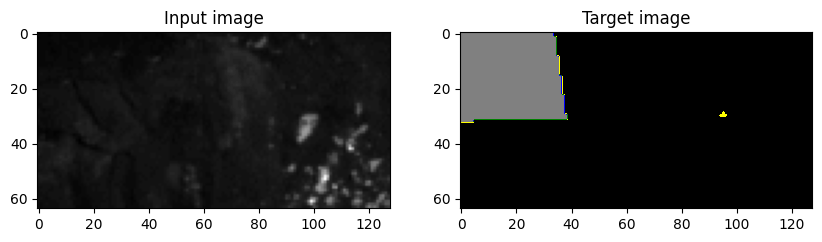

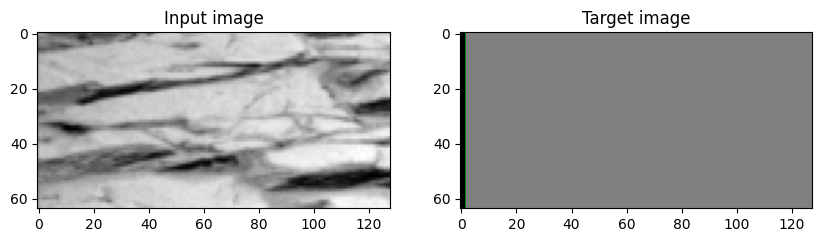

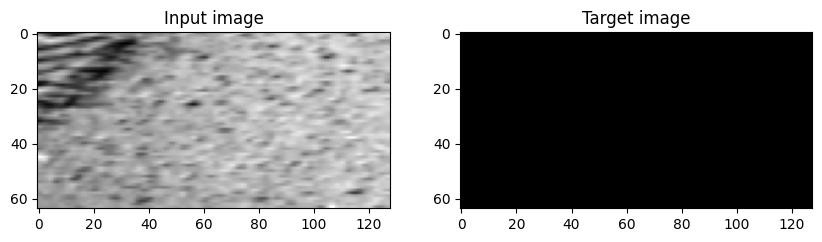

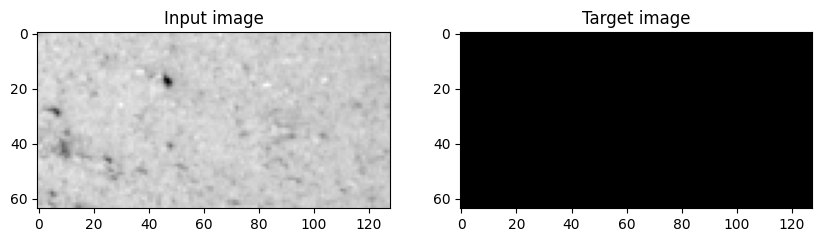

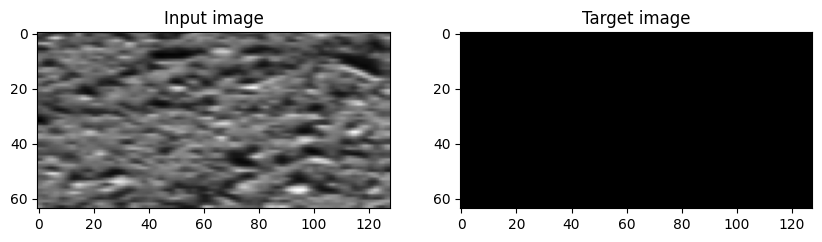

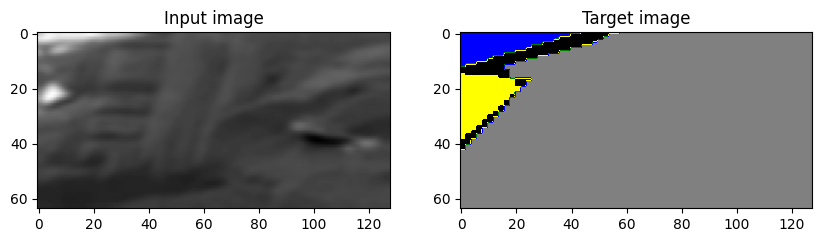

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [ ]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tfk.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 64)  │          128 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 64)  │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 128)  │          512 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)    

 Total params: 39,089,373 (149.11 MB)

 Trainable params: 39,067,859 (149.03 MB)

 Non-trainable params: 21,514 (84.04 KB)

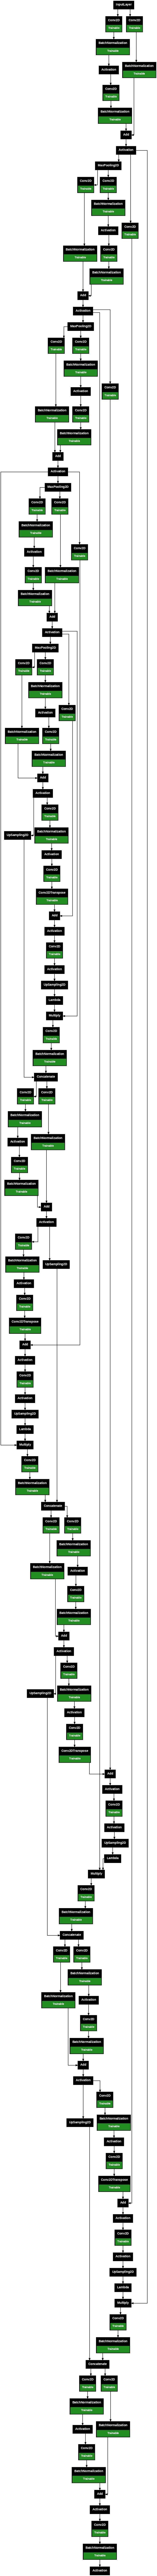

In [ ]:
model = Attention_ResUNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Compile the model
occ = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

for image in y_train:
    # detect if the image countains at least one pixel of a class
    for i in range(5):
        if i in image:
            occ[i] +=1

total_images = len(y_train)

# Calculate inverse frequency: 1 / (class frequency)
inverse_frequency = {class_id: total_images / occ[class_id] if occ[class_id] > 0 else 0 for class_id in occ}

ALPHA = 0.5
BETA = 0.5
GAMMA = 1

import tensorflow.keras.backend as K

def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):

        #flatten label and prediction tensors
        inputs = K.batch_flatten(inputs)
        targets = K.batch_flatten(targets)

        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        FocalTversky = K.pow((1 - Tversky), gamma)

        return FocalTversky

import tensorflow as tf

# Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    # Cross entropy loss
    cross_entropy_loss = -y_true * tf.math.log(y_pred)

    # Focal loss component
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy_loss
    return tf.reduce_sum(focal_loss, axis=-1)

# Dice Loss function
def dice_loss(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = 1 - (2.0 * intersection + epsilon) / (union + epsilon)
    return tf.reduce_mean(dice)

# Combined Loss function
def combined_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    focal = focal_loss(y_true, y_pred, alpha, gamma)
    dice = dice_loss(y_true, y_pred, epsilon)
    return tf.reduce_mean(focal + dice)



print("Compiling model...")
model.compile(
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(
    #    alpha=tf.constant(list(inverse_frequency.values()), dtype=tf.float32),
    #    gamma=2.0,
    #    label_smoothing = 0.1,
    #    from_logits=True,
    #    reduction = 'sum_over_batch_size',  # Common reduction method for multi-class classification
    #    axis = -1  # Typically, crossentropy is computed along the last axis
    #),
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=combined_loss,
    #loss=FocalTverskyLoss,
    # loss = tfk.losses.Tversky(
    #   alpha=0.5, beta=0.5, reduction="sum_over_batch_size", name="tversky", dtype=None
    # ),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=50,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.1,
    patience=40
)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3760 - loss: 1.5126 - mean_iou: 0.1547   

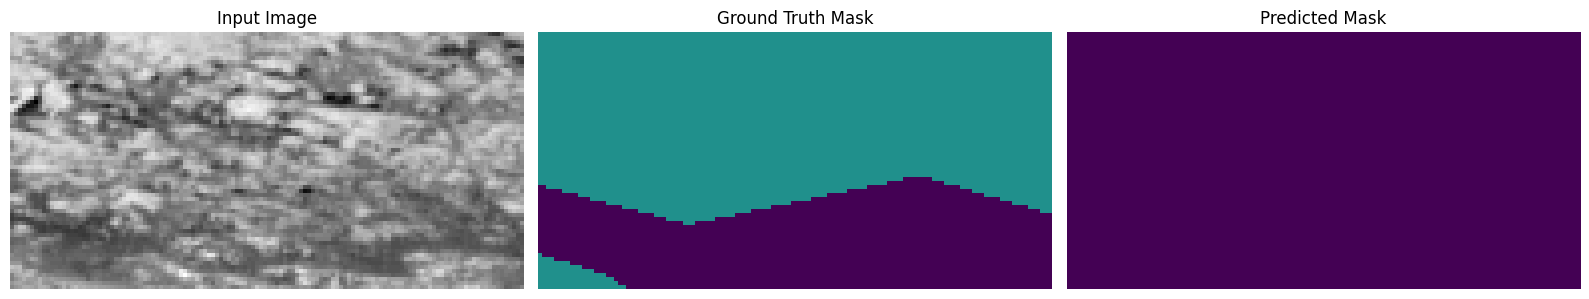

30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.3778 - loss: 1.5100 - mean_iou: 0.1556 - val_accuracy: 0.2445 - val_loss: 3.8721 - val_mean_iou: 0.0000e+00
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 734ms/step - accuracy: 0.4955 - loss: 1.2763 - mean_iou: 0.2303 - val_accuracy: 0.2760 - val_loss: 6.9409 - val_mean_iou: 0.0397
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step - accuracy: 0.5437 - loss: 1.1704 - mean_iou: 0.2685 - val_accuracy: 0.3827 - val_loss: 2.9067 - val_mean_iou: 0.1437
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 709ms/step - accuracy: 0.5646 - loss: 1.1101 - mean_iou: 0.2935 - val_accuracy: 0.2655 - val_loss: 2.9629 - val_mean_iou: 0.0816
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.5731 - loss: 1.0694 - mean_iou: 0.2889 - val_accuracy: 0.2801 - val_loss: 5.0373 - val_mean_iou: 0.0634
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.5996 - loss: 1.0094 - mean_iou: 0.3130

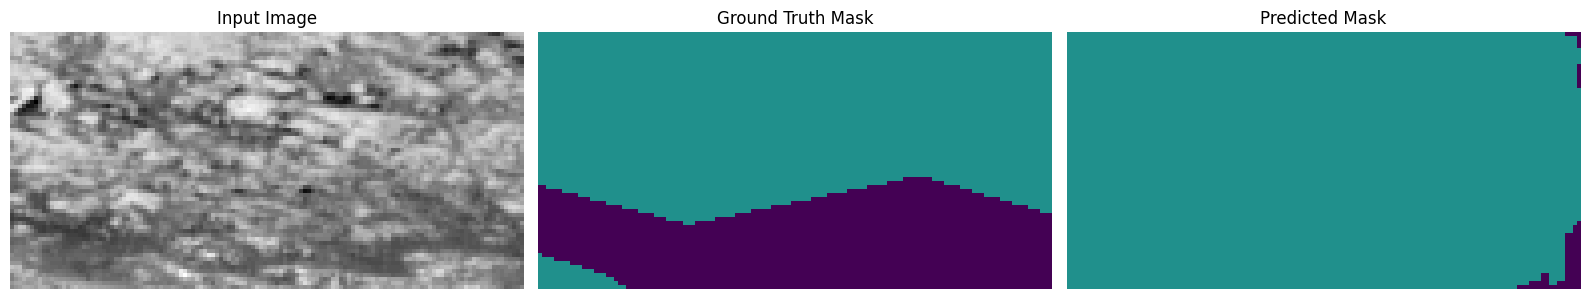

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.6001 - loss: 1.0080 - mean_iou: 0.3135 - val_accuracy: 0.3462 - val_loss: 3.6040 - val_mean_iou: 0.0940
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.6319 - loss: 0.9581 - mean_iou: 0.3390 - val_accuracy: 0.3238 - val_loss: 2.5478 - val_mean_iou: 0.0830
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.6374 - loss: 0.9398 - mean_iou: 0.3501 - val_accuracy: 0.4916 - val_loss: 1.5156 - val_mean_iou: 0.2096
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.6280 - loss: 0.9461 - mean_iou: 0.3348 - val_accuracy: 0.3305 - val_loss: 2.0686 - val_mean_iou: 0.0887
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.6307 - loss: 0.9517 - mean_iou: 0.3381 - val_accuracy: 0.3342 - val_loss: 2.4156 - val_mean_iou: 0.0854
Epoch 11/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6420 - loss: 0.9194 - mean_iou: 0.3538

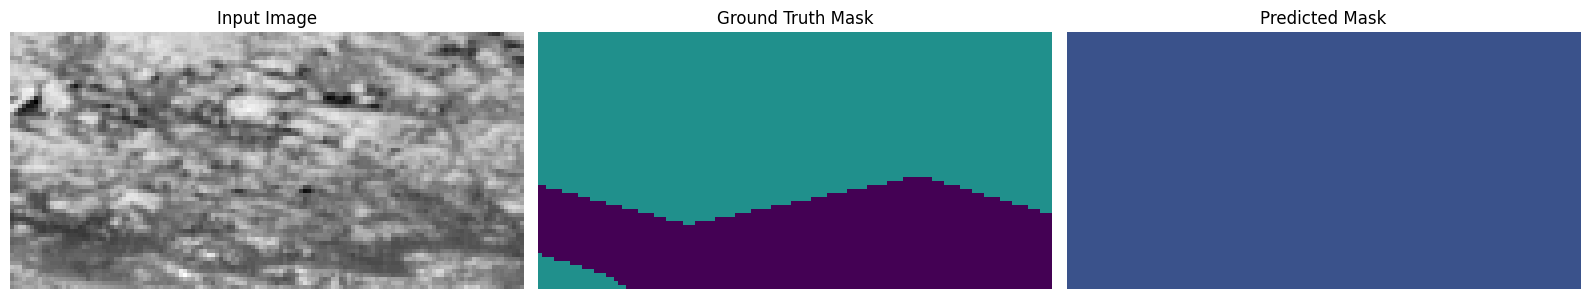

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.6424 - loss: 0.9186 - mean_iou: 0.3541 - val_accuracy: 0.5188 - val_loss: 1.5552 - val_mean_iou: 0.1899
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.6571 - loss: 0.8837 - mean_iou: 0.3685 - val_accuracy: 0.6048 - val_loss: 1.0836 - val_mean_iou: 0.3223
Epoch 13/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.6631 - loss: 0.8706 - mean_iou: 0.3700 - val_accuracy: 0.6077 - val_loss: 1.0450 - val_mean_iou: 0.3211
Epoch 14/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.6629 - loss: 0.8742 - mean_iou: 0.3716 - val_accuracy: 0.4711 - val_loss: 1.4430 - val_mean_iou: 0.2244
Epoch 15/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.6711 - loss: 0.8514 - mean_iou: 0.3801 - val_accuracy: 0.4100 - val_loss: 1.8762 - val_mean_iou: 0.1942
Epoch 16/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6787 - loss: 0.8436 - mean_iou: 0.3869

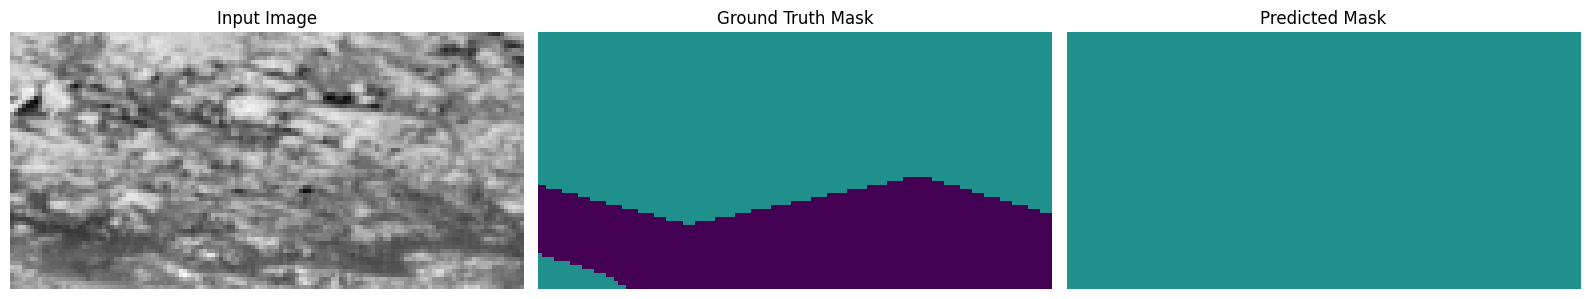

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.6791 - loss: 0.8423 - mean_iou: 0.3873 - val_accuracy: 0.5745 - val_loss: 1.2232 - val_mean_iou: 0.2875
Epoch 17/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.6788 - loss: 0.8362 - mean_iou: 0.3879 - val_accuracy: 0.6617 - val_loss: 0.8890 - val_mean_iou: 0.3818
Epoch 18/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.6911 - loss: 0.8137 - mean_iou: 0.3999 - val_accuracy: 0.6628 - val_loss: 0.9091 - val_mean_iou: 0.3769
Epoch 19/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.6966 - loss: 0.7887 - mean_iou: 0.4060 - val_accuracy: 0.3954 - val_loss: 1.4800 - val_mean_iou: 0.1463
Epoch 20/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.6925 - loss: 0.7920 - mean_iou: 0.4005 - val_accuracy: 0.4149 - val_loss: 1.8130 - val_mean_iou: 0.1453
Epoch 21/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.6883 - loss: 0.8041 - mean_iou: 0.3961

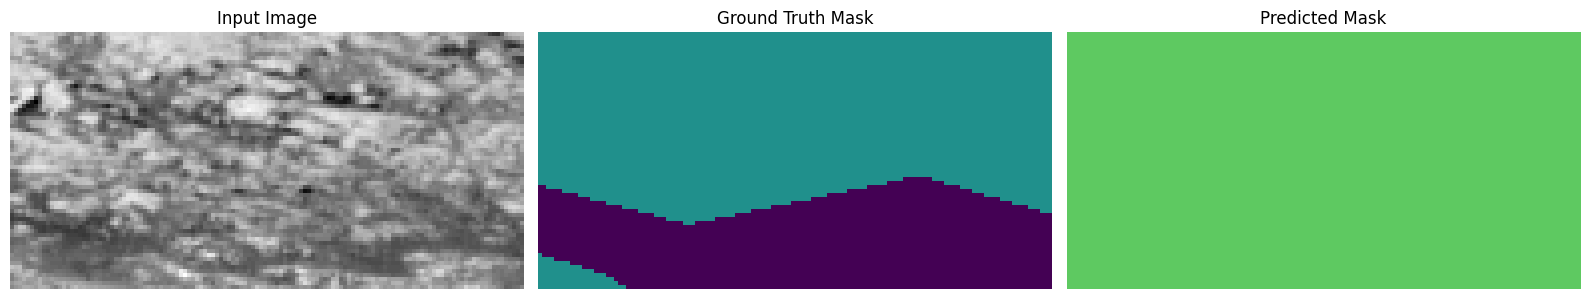

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.6886 - loss: 0.8032 - mean_iou: 0.3963 - val_accuracy: 0.3774 - val_loss: 2.2913 - val_mean_iou: 0.1194
Epoch 22/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.7203 - loss: 0.7437 - mean_iou: 0.4252 - val_accuracy: 0.5342 - val_loss: 1.2446 - val_mean_iou: 0.2239
Epoch 23/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.7088 - loss: 0.7632 - mean_iou: 0.4127 - val_accuracy: 0.4687 - val_loss: 1.5117 - val_mean_iou: 0.1794
Epoch 24/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7079 - loss: 0.7503 - mean_iou: 0.4142 - val_accuracy: 0.4323 - val_loss: 1.5922 - val_mean_iou: 0.1684
Epoch 25/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 713ms/step - accuracy: 0.7105 - loss: 0.7680 - mean_iou: 0.4159 - val_accuracy: 0.5383 - val_loss: 1.1744 - val_mean_iou: 0.2629
Epoch 26/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.7170 - loss: 0.7405 - mean_iou: 0.4237

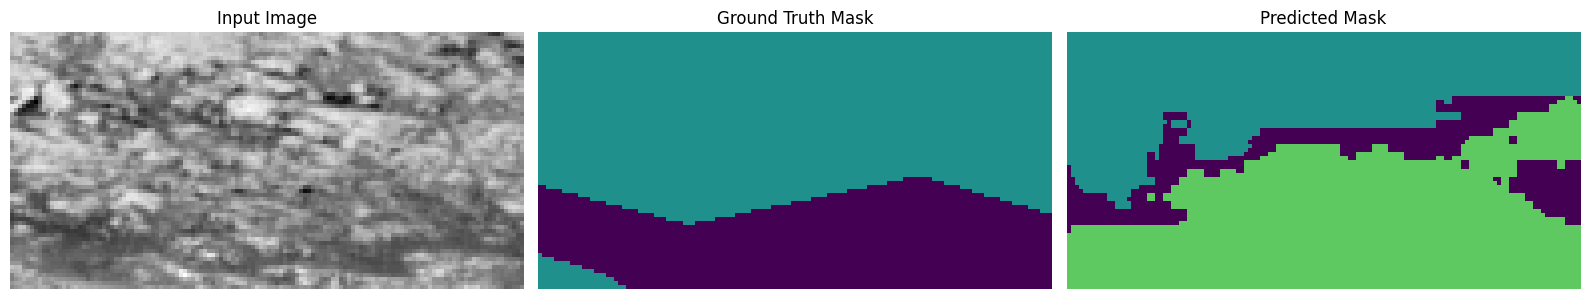

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.7173 - loss: 0.7398 - mean_iou: 0.4240 - val_accuracy: 0.5288 - val_loss: 1.4671 - val_mean_iou: 0.2265
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.7227 - loss: 0.7191 - mean_iou: 0.4255 - val_accuracy: 0.4649 - val_loss: 1.5905 - val_mean_iou: 0.2134
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7193 - loss: 0.7315 - mean_iou: 0.4182 - val_accuracy: 0.5641 - val_loss: 1.1995 - val_mean_iou: 0.2449
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.7240 - loss: 0.7303 - mean_iou: 0.4294 - val_accuracy: 0.5334 - val_loss: 1.4049 - val_mean_iou: 0.2747
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.7146 - loss: 0.7408 - mean_iou: 0.4149 - val_accuracy: 0.6747 - val_loss: 1.0077 - val_mean_iou: 0.3856
Epoch 31/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7289 - loss: 0.6975 - mean_iou: 0.4309

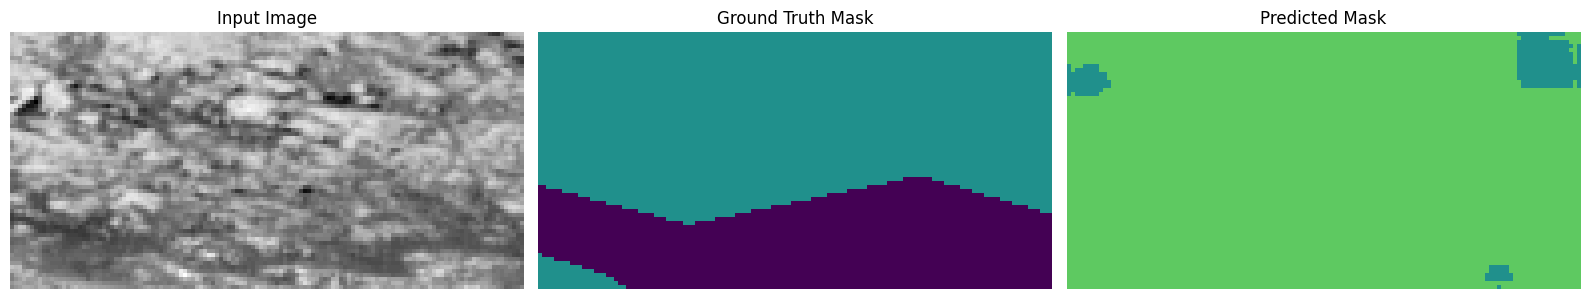

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.7292 - loss: 0.6970 - mean_iou: 0.4311 - val_accuracy: 0.5445 - val_loss: 1.5764 - val_mean_iou: 0.2660
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.7272 - loss: 0.7066 - mean_iou: 0.4270 - val_accuracy: 0.5589 - val_loss: 1.3552 - val_mean_iou: 0.2689
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.7285 - loss: 0.7101 - mean_iou: 0.4323 - val_accuracy: 0.4672 - val_loss: 2.1183 - val_mean_iou: 0.2162
Epoch 34/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.7370 - loss: 0.6844 - mean_iou: 0.4393 - val_accuracy: 0.6414 - val_loss: 1.0653 - val_mean_iou: 0.3404
Epoch 35/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.7456 - loss: 0.6823 - mean_iou: 0.4440 - val_accuracy: 0.5328 - val_loss: 1.5544 - val_mean_iou: 0.2744
Epoch 36/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7468 - loss: 0.6679 - mean_iou: 0.4536

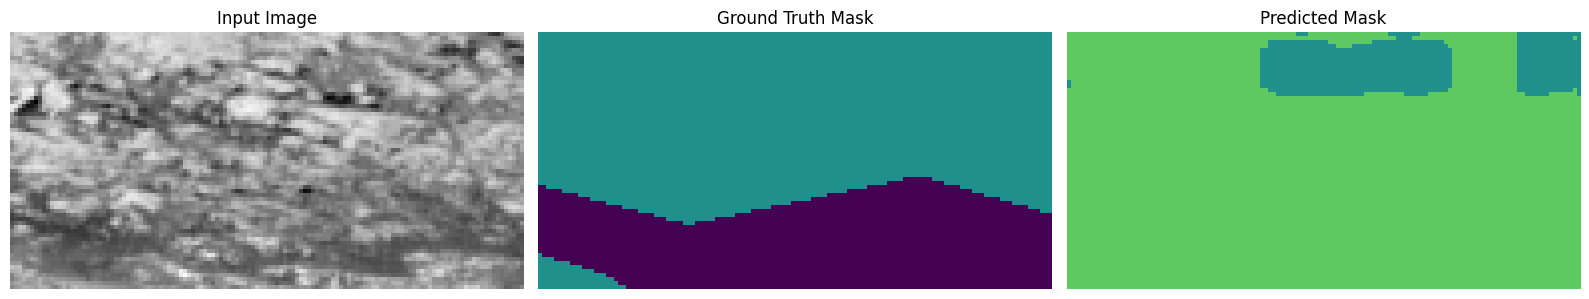

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 731ms/step - accuracy: 0.7470 - loss: 0.6674 - mean_iou: 0.4536 - val_accuracy: 0.6187 - val_loss: 1.2771 - val_mean_iou: 0.3381
Epoch 37/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.7424 - loss: 0.6826 - mean_iou: 0.4431 - val_accuracy: 0.7247 - val_loss: 0.7766 - val_mean_iou: 0.4117
Epoch 38/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.7492 - loss: 0.6611 - mean_iou: 0.4456 - val_accuracy: 0.6947 - val_loss: 0.8646 - val_mean_iou: 0.4015
Epoch 39/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.7444 - loss: 0.6656 - mean_iou: 0.4448 - val_accuracy: 0.7112 - val_loss: 0.8588 - val_mean_iou: 0.4104
Epoch 40/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7392 - loss: 0.6784 - mean_iou: 0.4395 - val_accuracy: 0.7052 - val_loss: 0.7550 - val_mean_iou: 0.3947
Epoch 41/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.7409 - loss: 0.6714 - mean_iou: 0.4419

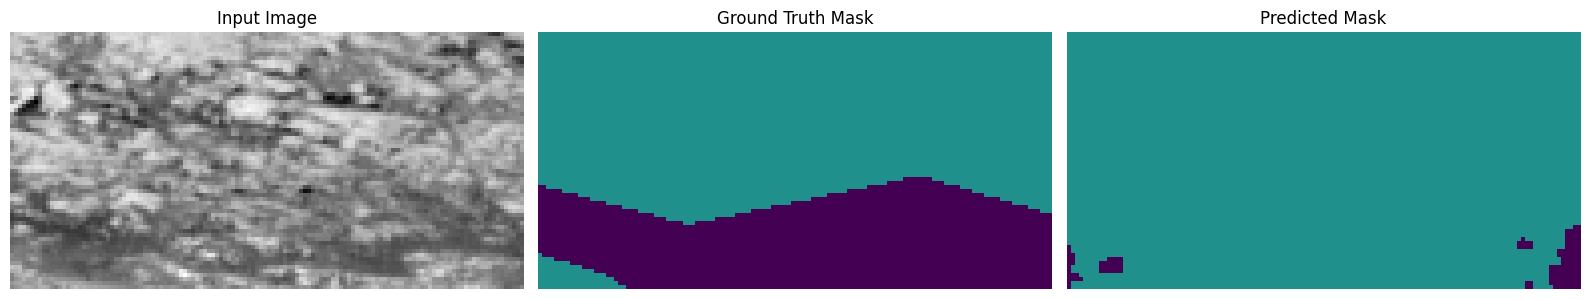

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 726ms/step - accuracy: 0.7413 - loss: 0.6705 - mean_iou: 0.4421 - val_accuracy: 0.6313 - val_loss: 1.0469 - val_mean_iou: 0.3324
Epoch 42/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7547 - loss: 0.6364 - mean_iou: 0.4533 - val_accuracy: 0.4546 - val_loss: 1.4868 - val_mean_iou: 0.1792
Epoch 43/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7503 - loss: 0.6584 - mean_iou: 0.4462 - val_accuracy: 0.5327 - val_loss: 1.1799 - val_mean_iou: 0.2480
Epoch 44/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.7504 - loss: 0.6486 - mean_iou: 0.4512 - val_accuracy: 0.3705 - val_loss: 2.2385 - val_mean_iou: 0.1083
Epoch 45/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.7627 - loss: 0.6118 - mean_iou: 0.4614 - val_accuracy: 0.3427 - val_loss: 2.7541 - val_mean_iou: 0.0841
Epoch 46/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.7562 - loss: 0.6379 - mean_iou: 0.4574

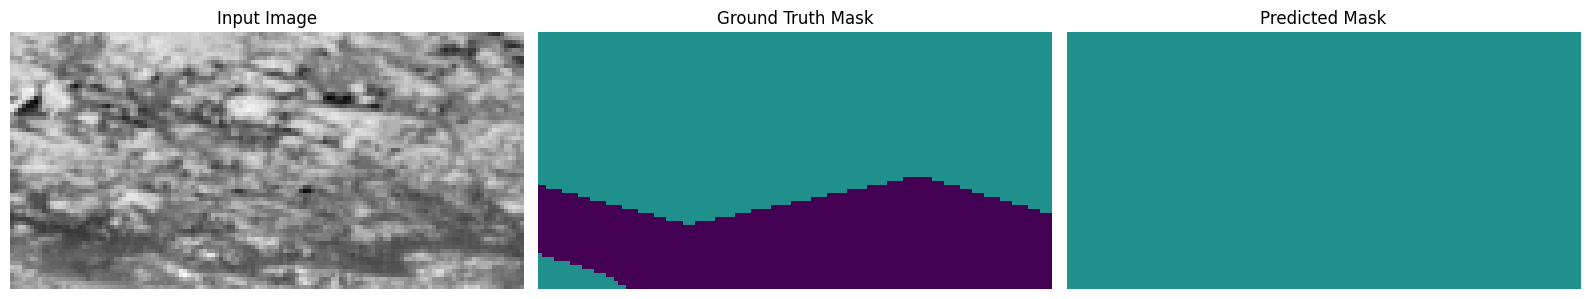

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 726ms/step - accuracy: 0.7565 - loss: 0.6369 - mean_iou: 0.4576 - val_accuracy: 0.6350 - val_loss: 1.0647 - val_mean_iou: 0.3270
Epoch 47/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.7628 - loss: 0.6118 - mean_iou: 0.4671 - val_accuracy: 0.5467 - val_loss: 1.2753 - val_mean_iou: 0.2445
Epoch 48/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.7631 - loss: 0.6165 - mean_iou: 0.4585 - val_accuracy: 0.6076 - val_loss: 1.1555 - val_mean_iou: 0.3005
Epoch 49/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.7623 - loss: 0.6144 - mean_iou: 0.4600 - val_accuracy: 0.6529 - val_loss: 1.0400 - val_mean_iou: 0.3201
Epoch 50/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.7702 - loss: 0.6251 - mean_iou: 0.4672 - val_accuracy: 0.4323 - val_loss: 2.0089 - val_mean_iou: 0.1514
Epoch 51/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7696 - loss: 0.6160 - mean_iou: 0.4631

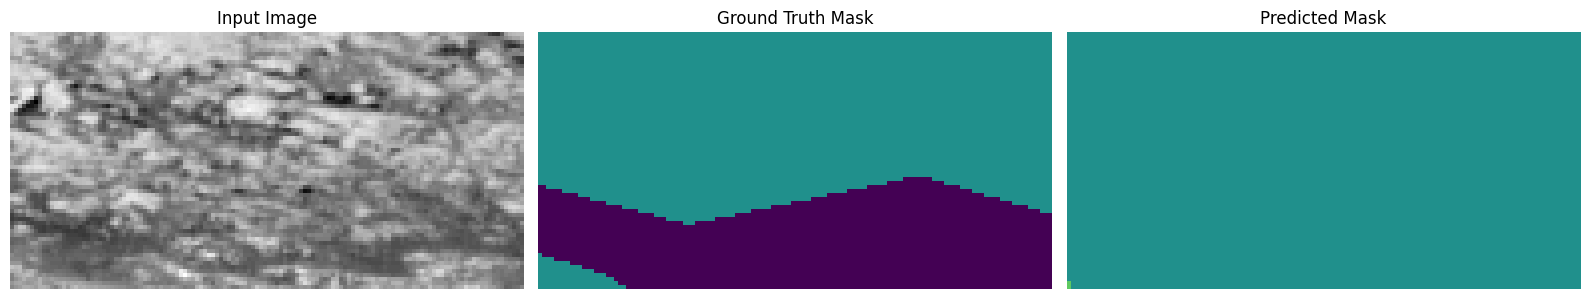

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 726ms/step - accuracy: 0.7700 - loss: 0.6151 - mean_iou: 0.4635 - val_accuracy: 0.6992 - val_loss: 0.8607 - val_mean_iou: 0.3824
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7667 - loss: 0.6187 - mean_iou: 0.4639 - val_accuracy: 0.6776 - val_loss: 1.0063 - val_mean_iou: 0.3722
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.7645 - loss: 0.6126 - mean_iou: 0.4712 - val_accuracy: 0.6011 - val_loss: 1.0237 - val_mean_iou: 0.2887
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.7745 - loss: 0.5954 - mean_iou: 0.4724 - val_accuracy: 0.6970 - val_loss: 0.8059 - val_mean_iou: 0.3780
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.7804 - loss: 0.5781 - mean_iou: 0.4748 - val_accuracy: 0.7294 - val_loss: 0.8026 - val_mean_iou: 0.4183
Epoch 56/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7787 - loss: 0.5828 - mean_iou: 0.4812

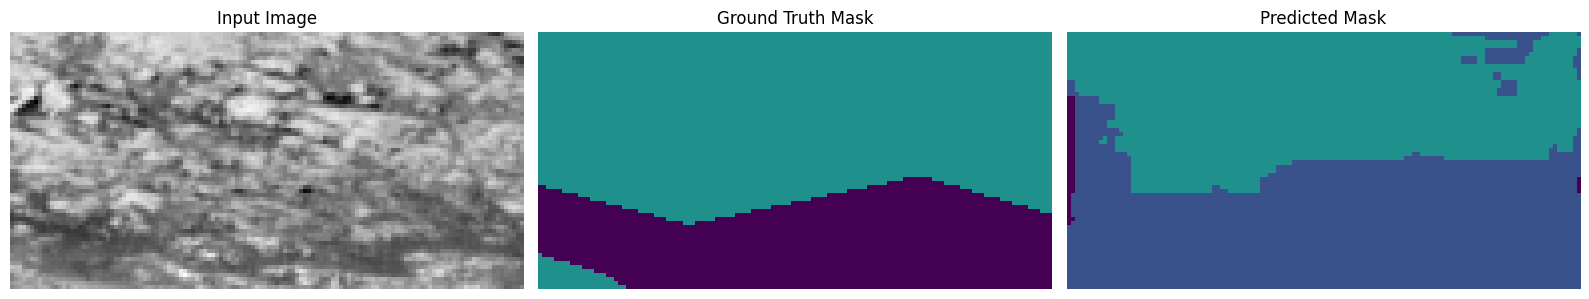

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.7789 - loss: 0.5823 - mean_iou: 0.4812 - val_accuracy: 0.7019 - val_loss: 0.8144 - val_mean_iou: 0.3809
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.7851 - loss: 0.5585 - mean_iou: 0.4769 - val_accuracy: 0.6392 - val_loss: 1.1877 - val_mean_iou: 0.3256
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.7859 - loss: 0.5614 - mean_iou: 0.4802 - val_accuracy: 0.6929 - val_loss: 0.8564 - val_mean_iou: 0.3691
Epoch 59/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.7833 - loss: 0.5694 - mean_iou: 0.4738 - val_accuracy: 0.7005 - val_loss: 0.8956 - val_mean_iou: 0.3808
Epoch 60/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 711ms/step - accuracy: 0.7939 - loss: 0.5450 - mean_iou: 0.4875 - val_accuracy: 0.6663 - val_loss: 0.9430 - val_mean_iou: 0.3393
Epoch 61/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.7987 - loss: 0.5234 - mean_iou: 0.4940

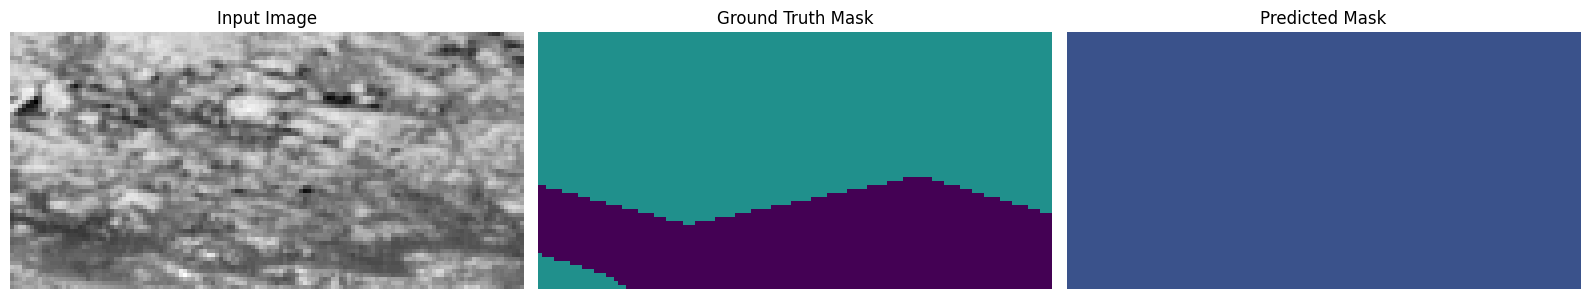

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 749ms/step - accuracy: 0.7987 - loss: 0.5233 - mean_iou: 0.4941 - val_accuracy: 0.4999 - val_loss: 1.4954 - val_mean_iou: 0.1924
Epoch 62/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.7924 - loss: 0.5420 - mean_iou: 0.4827 - val_accuracy: 0.6358 - val_loss: 1.1299 - val_mean_iou: 0.3108
Epoch 63/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 709ms/step - accuracy: 0.7986 - loss: 0.5244 - mean_iou: 0.4895 - val_accuracy: 0.7156 - val_loss: 0.7872 - val_mean_iou: 0.3931
Epoch 64/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7971 - loss: 0.5318 - mean_iou: 0.4879 - val_accuracy: 0.7135 - val_loss: 0.8026 - val_mean_iou: 0.4104
Epoch 65/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 720ms/step - accuracy: 0.8135 - loss: 0.4893 - mean_iou: 0.5011 - val_accuracy: 0.7129 - val_loss: 0.8091 - val_mean_iou: 0.3965
Epoch 66/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8067 - loss: 0.5185 - mean_iou: 0.4972

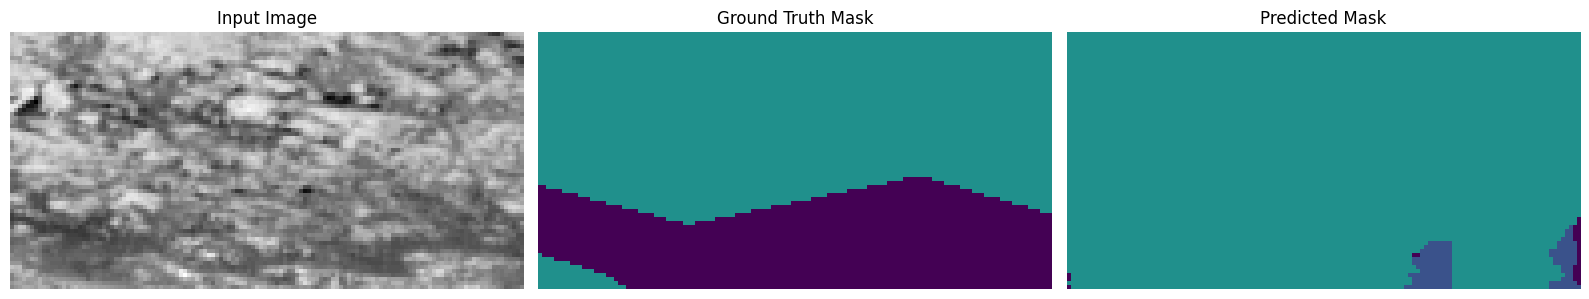

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - accuracy: 0.8068 - loss: 0.5181 - mean_iou: 0.4971 - val_accuracy: 0.7337 - val_loss: 0.7931 - val_mean_iou: 0.4088
Epoch 67/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 713ms/step - accuracy: 0.8000 - loss: 0.5116 - mean_iou: 0.4925 - val_accuracy: 0.7019 - val_loss: 0.8838 - val_mean_iou: 0.3846
Epoch 68/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 704ms/step - accuracy: 0.8118 - loss: 0.4995 - mean_iou: 0.4958 - val_accuracy: 0.6638 - val_loss: 1.0962 - val_mean_iou: 0.3224
Epoch 69/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.8176 - loss: 0.4842 - mean_iou: 0.5029 - val_accuracy: 0.6667 - val_loss: 0.9225 - val_mean_iou: 0.3611
Epoch 70/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.8181 - loss: 0.4863 - mean_iou: 0.5033 - val_accuracy: 0.4023 - val_loss: 1.9252 - val_mean_iou: 0.1358
Epoch 71/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8112 - loss: 0.4948 - mean_iou: 0.4974

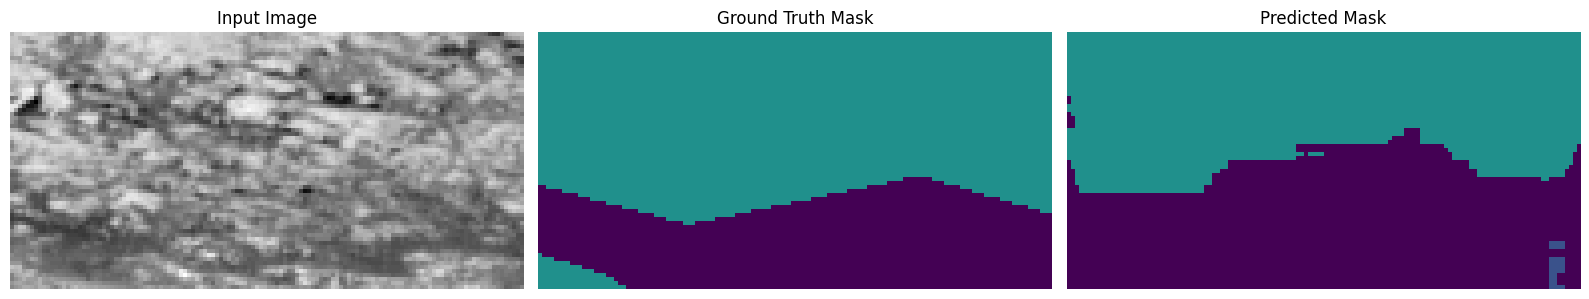

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 729ms/step - accuracy: 0.8114 - loss: 0.4944 - mean_iou: 0.4976 - val_accuracy: 0.5969 - val_loss: 1.1554 - val_mean_iou: 0.2908
Epoch 72/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.8125 - loss: 0.4906 - mean_iou: 0.5015 - val_accuracy: 0.2829 - val_loss: 3.1762 - val_mean_iou: 0.0418
Epoch 73/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.8233 - loss: 0.4624 - mean_iou: 0.5092 - val_accuracy: 0.4108 - val_loss: 1.8517 - val_mean_iou: 0.1458
Epoch 74/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.8301 - loss: 0.4577 - mean_iou: 0.5133 - val_accuracy: 0.7353 - val_loss: 0.7442 - val_mean_iou: 0.4299
Epoch 75/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.8340 - loss: 0.4410 - mean_iou: 0.5185 - val_accuracy: 0.6978 - val_loss: 0.8268 - val_mean_iou: 0.3948
Epoch 76/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.8294 - loss: 0.4483 - mean_iou: 0.5129

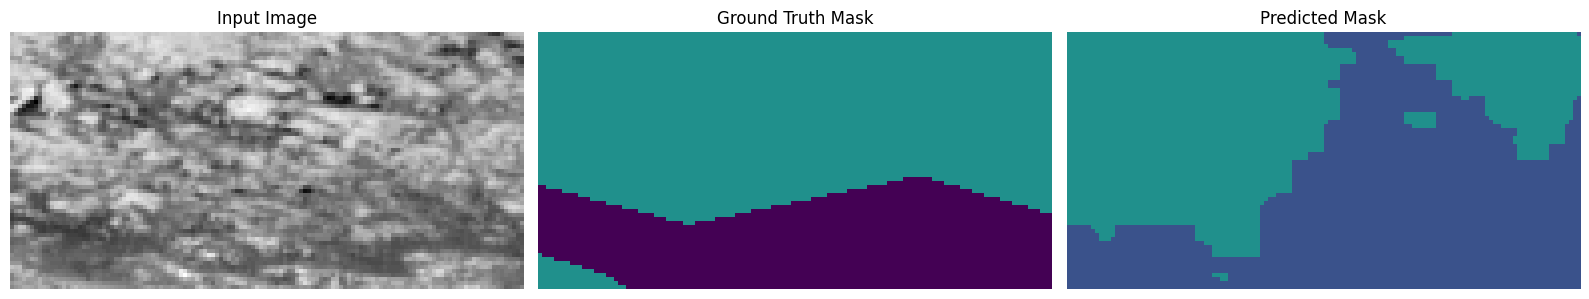

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 730ms/step - accuracy: 0.8294 - loss: 0.4482 - mean_iou: 0.5129 - val_accuracy: 0.7127 - val_loss: 0.8495 - val_mean_iou: 0.4341
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.8330 - loss: 0.4524 - mean_iou: 0.5133 - val_accuracy: 0.7347 - val_loss: 0.7871 - val_mean_iou: 0.4300
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.8394 - loss: 0.4280 - mean_iou: 0.5159 - val_accuracy: 0.5725 - val_loss: 1.2386 - val_mean_iou: 0.2752
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.8348 - loss: 0.4342 - mean_iou: 0.5189 - val_accuracy: 0.6975 - val_loss: 0.8189 - val_mean_iou: 0.3822
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.8429 - loss: 0.4195 - mean_iou: 0.5201 - val_accuracy: 0.6924 - val_loss: 0.9008 - val_mean_iou: 0.3701
Epoch 81/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8317 - loss: 0.4497 - mean_iou: 0.5119

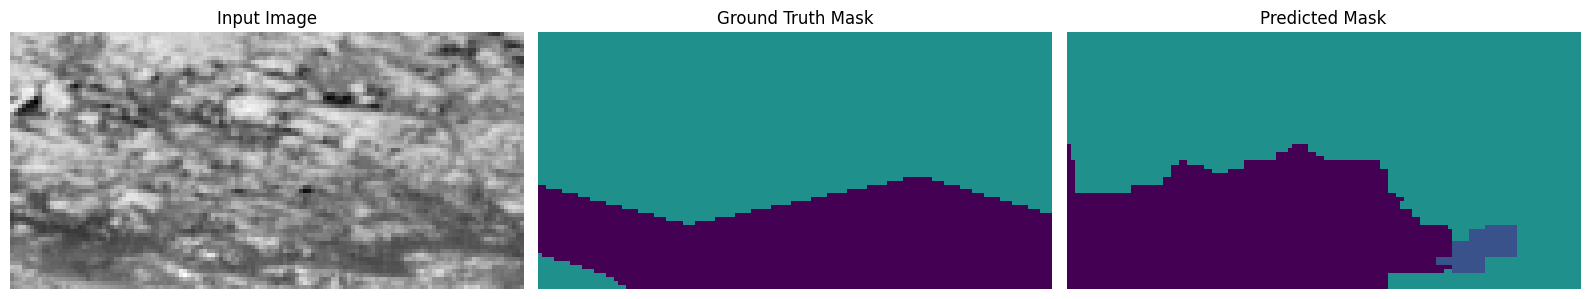

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.8320 - loss: 0.4488 - mean_iou: 0.5120 - val_accuracy: 0.7437 - val_loss: 0.7361 - val_mean_iou: 0.4471
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.8447 - loss: 0.4147 - mean_iou: 0.5201 - val_accuracy: 0.7026 - val_loss: 0.9491 - val_mean_iou: 0.4130
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.8464 - loss: 0.4166 - mean_iou: 0.5205 - val_accuracy: 0.7081 - val_loss: 0.8823 - val_mean_iou: 0.4004
Epoch 84/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.8416 - loss: 0.4127 - mean_iou: 0.5177 - val_accuracy: 0.7228 - val_loss: 0.8738 - val_mean_iou: 0.4165
Epoch 85/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.8618 - loss: 0.3756 - mean_iou: 0.5337 - val_accuracy: 0.6370 - val_loss: 1.0012 - val_mean_iou: 0.3325
Epoch 86/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8431 - loss: 0.4197 - mean_iou: 0.5244

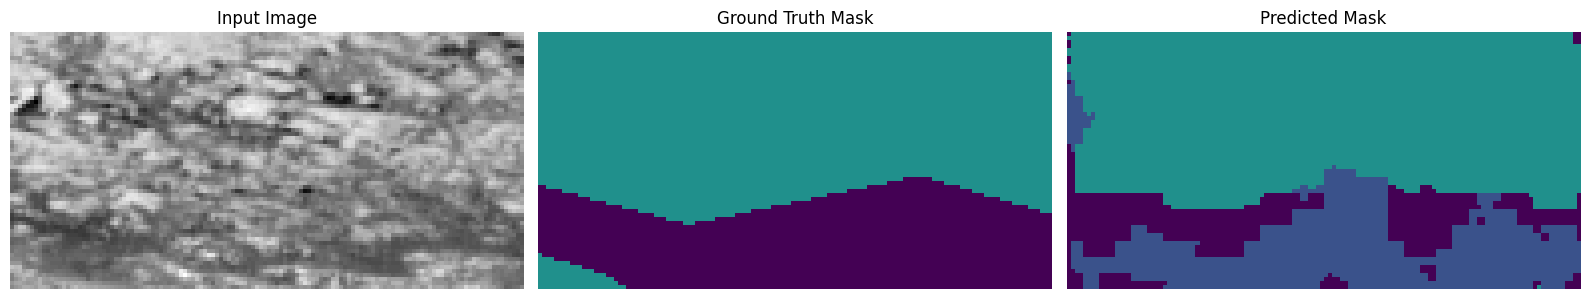

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 736ms/step - accuracy: 0.8434 - loss: 0.4188 - mean_iou: 0.5245 - val_accuracy: 0.7489 - val_loss: 0.7196 - val_mean_iou: 0.4308
Epoch 87/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8635 - loss: 0.3699 - mean_iou: 0.5286 - val_accuracy: 0.7464 - val_loss: 0.7355 - val_mean_iou: 0.4392
Epoch 88/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.8603 - loss: 0.3759 - mean_iou: 0.5295 - val_accuracy: 0.7027 - val_loss: 0.9168 - val_mean_iou: 0.3901
Epoch 89/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.8673 - loss: 0.3587 - mean_iou: 0.5473 - val_accuracy: 0.6440 - val_loss: 1.1657 - val_mean_iou: 0.3189
Epoch 90/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8651 - loss: 0.3682 - mean_iou: 0.5439 - val_accuracy: 0.7043 - val_loss: 0.8555 - val_mean_iou: 0.3816
Epoch 91/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8686 - loss: 0.3486 - mean_iou: 0.5504

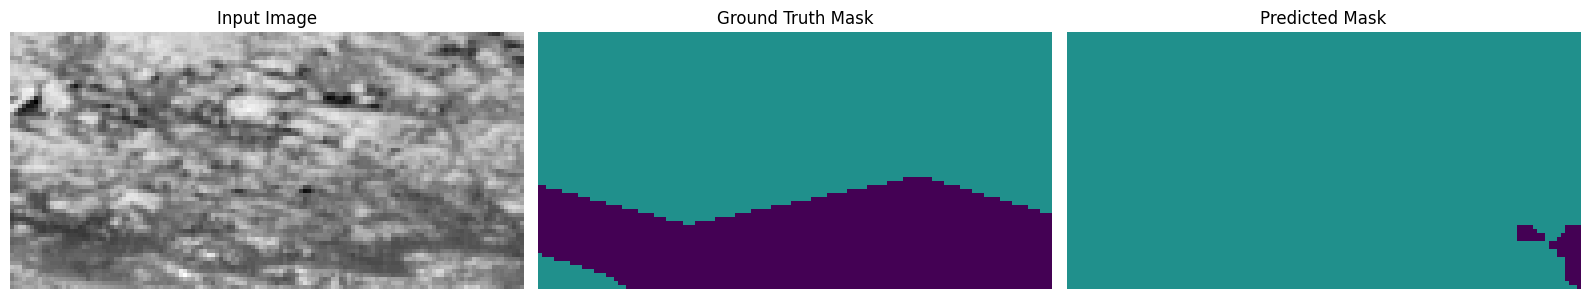

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 730ms/step - accuracy: 0.8688 - loss: 0.3481 - mean_iou: 0.5507 - val_accuracy: 0.7576 - val_loss: 0.7136 - val_mean_iou: 0.4359
Epoch 92/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 726ms/step - accuracy: 0.8828 - loss: 0.3149 - mean_iou: 0.5548 - val_accuracy: 0.7082 - val_loss: 0.8688 - val_mean_iou: 0.3817
Epoch 93/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8828 - loss: 0.3153 - mean_iou: 0.5572 - val_accuracy: 0.7438 - val_loss: 0.8064 - val_mean_iou: 0.4166
Epoch 94/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.8806 - loss: 0.3223 - mean_iou: 0.5462 - val_accuracy: 0.7044 - val_loss: 0.9461 - val_mean_iou: 0.3861
Epoch 95/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.8839 - loss: 0.3143 - mean_iou: 0.5624 - val_accuracy: 0.6754 - val_loss: 1.0029 - val_mean_iou: 0.3520
Epoch 96/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.8877 - loss: 0.3045 - mean_iou: 0.5557

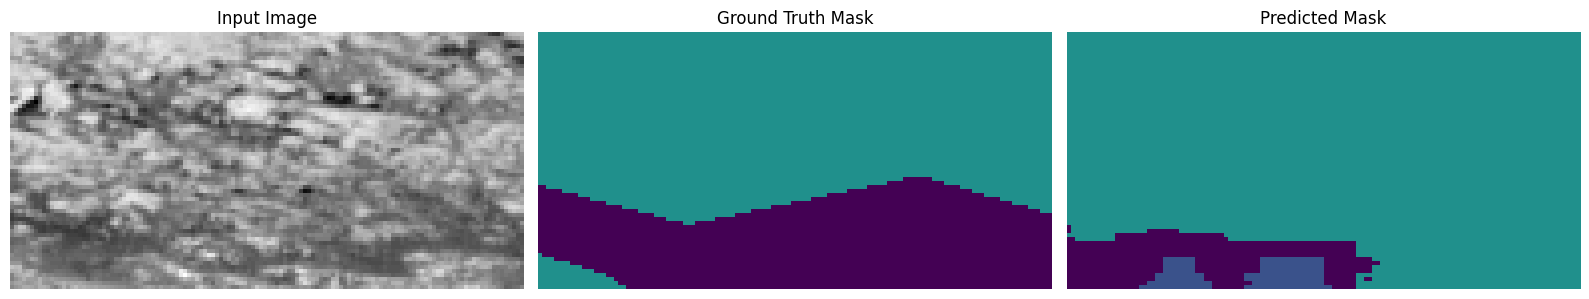

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 734ms/step - accuracy: 0.8875 - loss: 0.3050 - mean_iou: 0.5556 - val_accuracy: 0.7475 - val_loss: 0.7522 - val_mean_iou: 0.4422
Epoch 97/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.8839 - loss: 0.3169 - mean_iou: 0.5610 - val_accuracy: 0.7527 - val_loss: 0.7167 - val_mean_iou: 0.4315
Epoch 98/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.8893 - loss: 0.3060 - mean_iou: 0.5578 - val_accuracy: 0.6692 - val_loss: 1.0220 - val_mean_iou: 0.3495
Epoch 99/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.8867 - loss: 0.3057 - mean_iou: 0.5524 - val_accuracy: 0.5911 - val_loss: 1.1119 - val_mean_iou: 0.2942
Epoch 100/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.8794 - loss: 0.3224 - mean_iou: 0.5589 - val_accuracy: 0.5706 - val_loss: 1.2365 - val_mean_iou: 0.2774
Epoch 101/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8912 - loss: 0.3018 - mean_iou: 0.5689

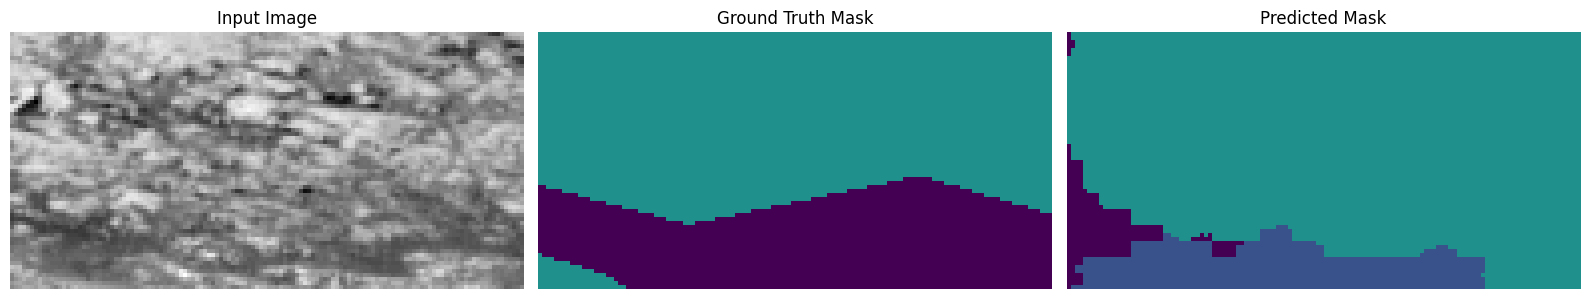

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 732ms/step - accuracy: 0.8911 - loss: 0.3017 - mean_iou: 0.5690 - val_accuracy: 0.5632 - val_loss: 1.3798 - val_mean_iou: 0.2479
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.9011 - loss: 0.2755 - mean_iou: 0.5706 - val_accuracy: 0.7272 - val_loss: 0.8251 - val_mean_iou: 0.4099
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.8910 - loss: 0.2972 - mean_iou: 0.5591 - val_accuracy: 0.7284 - val_loss: 0.8184 - val_mean_iou: 0.4226
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.8931 - loss: 0.2852 - mean_iou: 0.5582 - val_accuracy: 0.7548 - val_loss: 0.7656 - val_mean_iou: 0.4388
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 726ms/step - accuracy: 0.9033 - loss: 0.2690 - mean_iou: 0.5873 - val_accuracy: 0.7450 - val_loss: 0.8580 - val_mean_iou: 0.4347
Epoch 106/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8995 - loss: 0.2738 - mean_iou: 0.5770

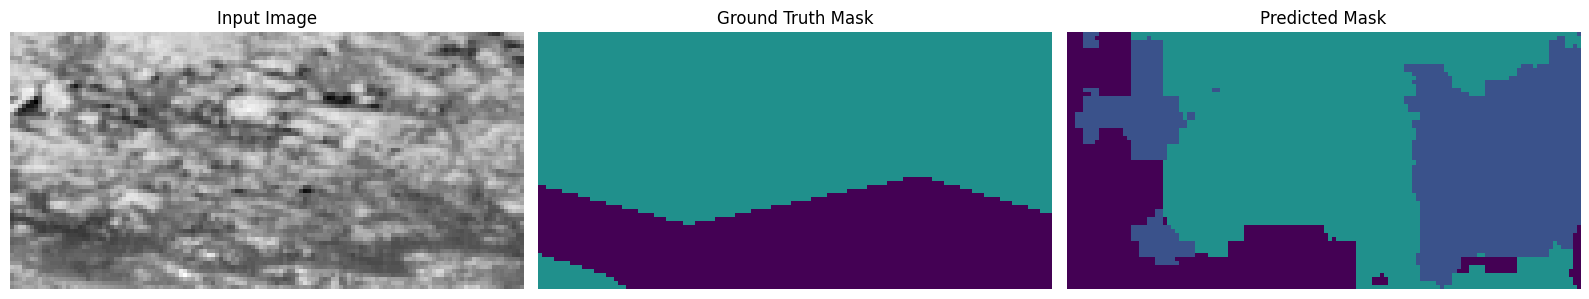

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 735ms/step - accuracy: 0.8996 - loss: 0.2737 - mean_iou: 0.5773 - val_accuracy: 0.7345 - val_loss: 0.7910 - val_mean_iou: 0.4246
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.9056 - loss: 0.2594 - mean_iou: 0.5892 - val_accuracy: 0.7425 - val_loss: 0.8680 - val_mean_iou: 0.4223
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.8941 - loss: 0.2900 - mean_iou: 0.5882 - val_accuracy: 0.7360 - val_loss: 0.7827 - val_mean_iou: 0.4202
Epoch 109/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9037 - loss: 0.2674 - mean_iou: 0.5862 - val_accuracy: 0.7278 - val_loss: 0.8526 - val_mean_iou: 0.4159
Epoch 110/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 729ms/step - accuracy: 0.9006 - loss: 0.2697 - mean_iou: 0.6071 - val_accuracy: 0.7240 - val_loss: 0.8892 - val_mean_iou: 0.4109
Epoch 111/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9080 - loss: 0.2487 - mean_iou: 0.6070

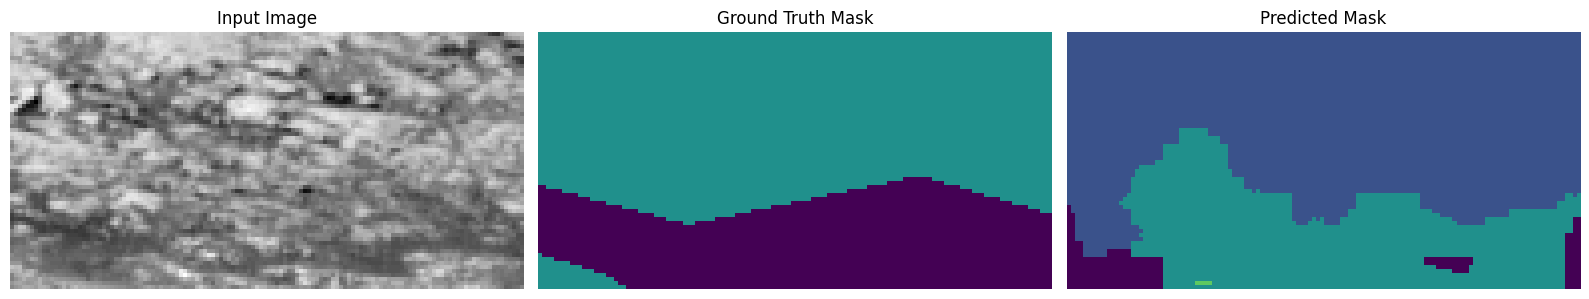

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 736ms/step - accuracy: 0.9080 - loss: 0.2487 - mean_iou: 0.6071 - val_accuracy: 0.7167 - val_loss: 0.8754 - val_mean_iou: 0.4139
Epoch 112/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9132 - loss: 0.2357 - mean_iou: 0.5928 - val_accuracy: 0.7034 - val_loss: 0.9530 - val_mean_iou: 0.3838
Epoch 113/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 730ms/step - accuracy: 0.9195 - loss: 0.2240 - mean_iou: 0.5747 - val_accuracy: 0.7435 - val_loss: 0.7920 - val_mean_iou: 0.4513
Epoch 114/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9194 - loss: 0.2217 - mean_iou: 0.6211 - val_accuracy: 0.6809 - val_loss: 1.0985 - val_mean_iou: 0.3534
Epoch 115/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.9130 - loss: 0.2390 - mean_iou: 0.6202 - val_accuracy: 0.6869 - val_loss: 0.9311 - val_mean_iou: 0.3613
Epoch 116/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9202 - loss: 0.2214 - mean_iou: 0.6023

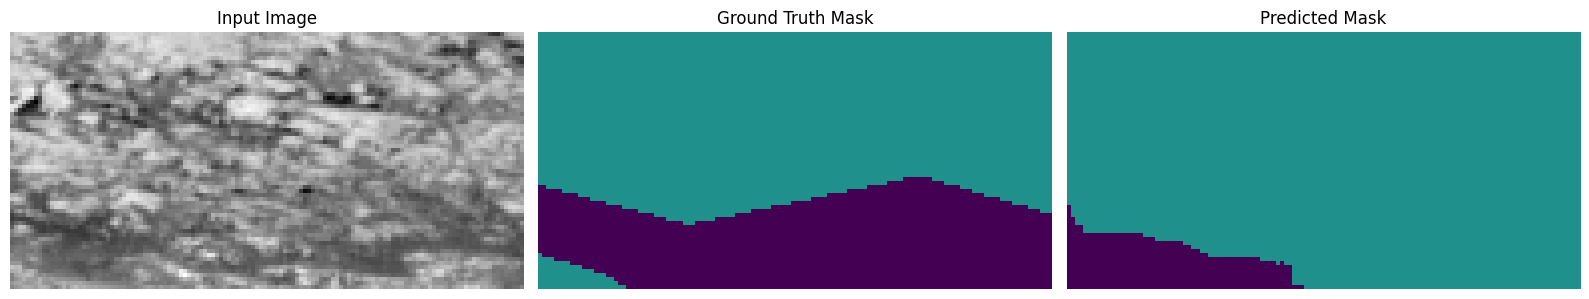

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 736ms/step - accuracy: 0.9202 - loss: 0.2215 - mean_iou: 0.6025 - val_accuracy: 0.7632 - val_loss: 0.7852 - val_mean_iou: 0.4550
Epoch 117/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9240 - loss: 0.2074 - mean_iou: 0.6494 - val_accuracy: 0.7029 - val_loss: 0.9251 - val_mean_iou: 0.3714
Epoch 118/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9267 - loss: 0.1995 - mean_iou: 0.6199 - val_accuracy: 0.6843 - val_loss: 1.0279 - val_mean_iou: 0.3633
Epoch 119/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.9218 - loss: 0.2146 - mean_iou: 0.6284 - val_accuracy: 0.6581 - val_loss: 1.2840 - val_mean_iou: 0.3245
Epoch 120/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 716ms/step - accuracy: 0.9205 - loss: 0.2143 - mean_iou: 0.6265 - val_accuracy: 0.7412 - val_loss: 0.7616 - val_mean_iou: 0.4267
Epoch 121/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9289 - loss: 0.1960 - mean_iou: 0.6394

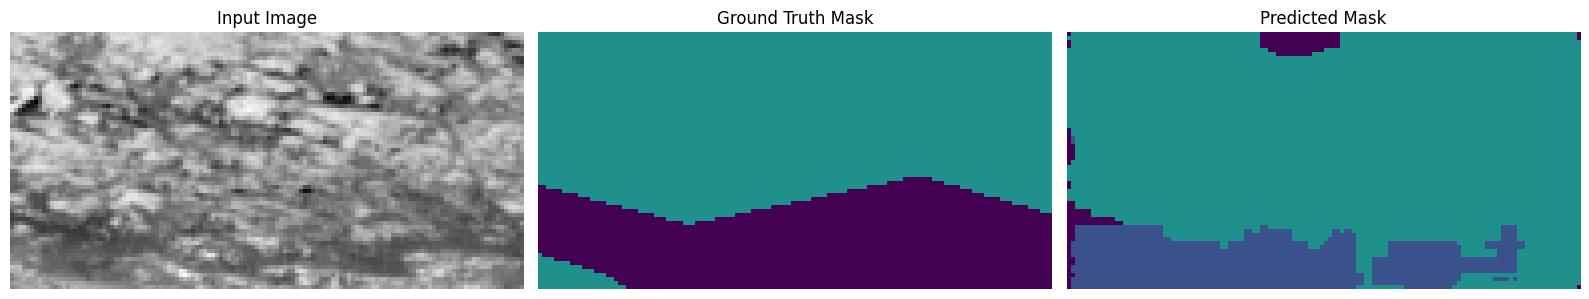

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 753ms/step - accuracy: 0.9289 - loss: 0.1960 - mean_iou: 0.6394 - val_accuracy: 0.6871 - val_loss: 0.9773 - val_mean_iou: 0.3585
Epoch 122/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9251 - loss: 0.2043 - mean_iou: 0.6350 - val_accuracy: 0.6853 - val_loss: 1.0567 - val_mean_iou: 0.3712
Epoch 123/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 711ms/step - accuracy: 0.9298 - loss: 0.1891 - mean_iou: 0.6274 - val_accuracy: 0.7100 - val_loss: 1.0176 - val_mean_iou: 0.3858
Epoch 124/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9287 - loss: 0.1941 - mean_iou: 0.6472 - val_accuracy: 0.7357 - val_loss: 0.8587 - val_mean_iou: 0.4151
Epoch 125/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.9375 - loss: 0.1705 - mean_iou: 0.6649 - val_accuracy: 0.7285 - val_loss: 0.8524 - val_mean_iou: 0.4058
Epoch 126/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9361 - loss: 0.1725 - mean_iou: 0.6646

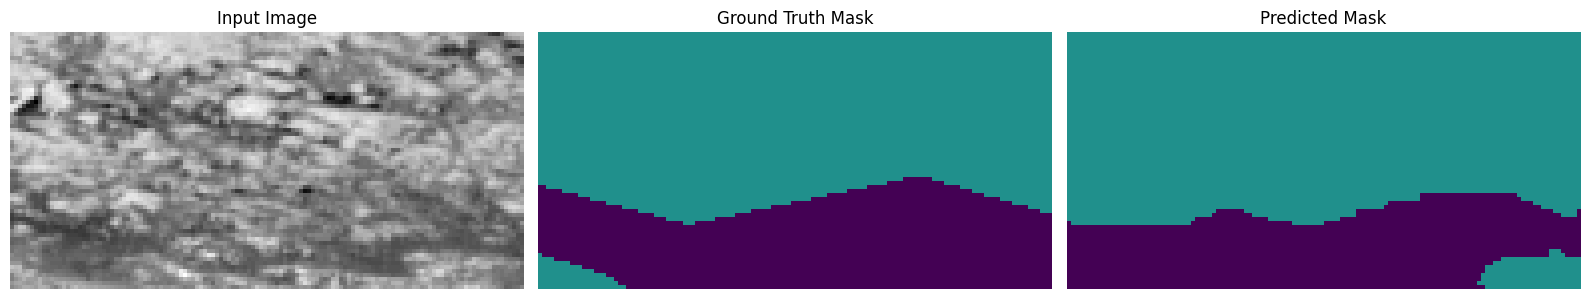

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 730ms/step - accuracy: 0.9361 - loss: 0.1725 - mean_iou: 0.6648 - val_accuracy: 0.7470 - val_loss: 0.7603 - val_mean_iou: 0.4478
Epoch 127/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.9325 - loss: 0.1873 - mean_iou: 0.6557 - val_accuracy: 0.6527 - val_loss: 1.2997 - val_mean_iou: 0.3336
Epoch 128/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9202 - loss: 0.2213 - mean_iou: 0.6291 - val_accuracy: 0.7185 - val_loss: 0.9855 - val_mean_iou: 0.4053
Epoch 129/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.9343 - loss: 0.1796 - mean_iou: 0.6565 - val_accuracy: 0.7395 - val_loss: 0.9061 - val_mean_iou: 0.4206
Epoch 130/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9409 - loss: 0.1616 - mean_iou: 0.6801 - val_accuracy: 0.7300 - val_loss: 0.9136 - val_mean_iou: 0.4148
Epoch 131/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9369 - loss: 0.1721 - mean_iou: 0.6630

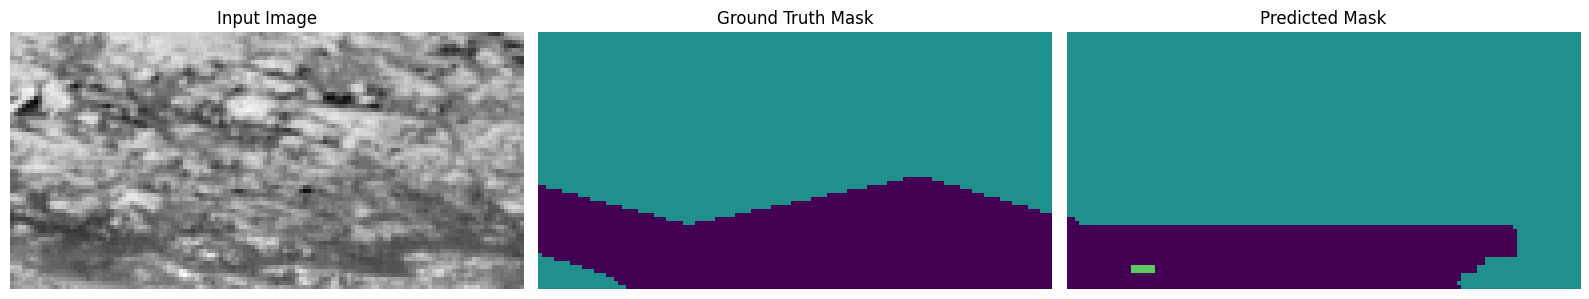

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.9369 - loss: 0.1721 - mean_iou: 0.6629 - val_accuracy: 0.7596 - val_loss: 0.7984 - val_mean_iou: 0.4542
Epoch 132/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.9399 - loss: 0.1630 - mean_iou: 0.6631 - val_accuracy: 0.7538 - val_loss: 0.8332 - val_mean_iou: 0.4414
Epoch 133/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9392 - loss: 0.1627 - mean_iou: 0.6729 - val_accuracy: 0.7479 - val_loss: 0.8759 - val_mean_iou: 0.4298
Epoch 134/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9398 - loss: 0.1638 - mean_iou: 0.6773 - val_accuracy: 0.7686 - val_loss: 0.7665 - val_mean_iou: 0.4546
Epoch 135/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9410 - loss: 0.1598 - mean_iou: 0.6857 - val_accuracy: 0.6181 - val_loss: 1.2382 - val_mean_iou: 0.3155
Epoch 136/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9206 - loss: 0.2217 - mean_iou: 0.6437

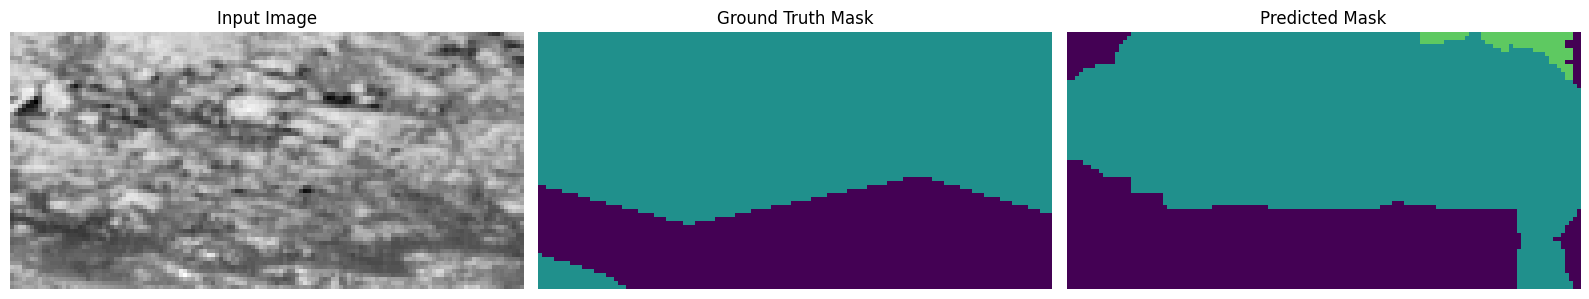

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.9207 - loss: 0.2213 - mean_iou: 0.6439 - val_accuracy: 0.7094 - val_loss: 1.1140 - val_mean_iou: 0.3899
Epoch 137/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.9316 - loss: 0.1833 - mean_iou: 0.6745 - val_accuracy: 0.7653 - val_loss: 0.8330 - val_mean_iou: 0.4552
Epoch 138/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.9352 - loss: 0.1744 - mean_iou: 0.6422 - val_accuracy: 0.7327 - val_loss: 0.9004 - val_mean_iou: 0.4193
Epoch 139/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9427 - loss: 0.1551 - mean_iou: 0.6744 - val_accuracy: 0.7585 - val_loss: 0.8503 - val_mean_iou: 0.4389
Epoch 140/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.9435 - loss: 0.1536 - mean_iou: 0.6729 - val_accuracy: 0.7476 - val_loss: 0.8692 - val_mean_iou: 0.4269
Epoch 141/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9435 - loss: 0.1534 - mean_iou: 0.6789

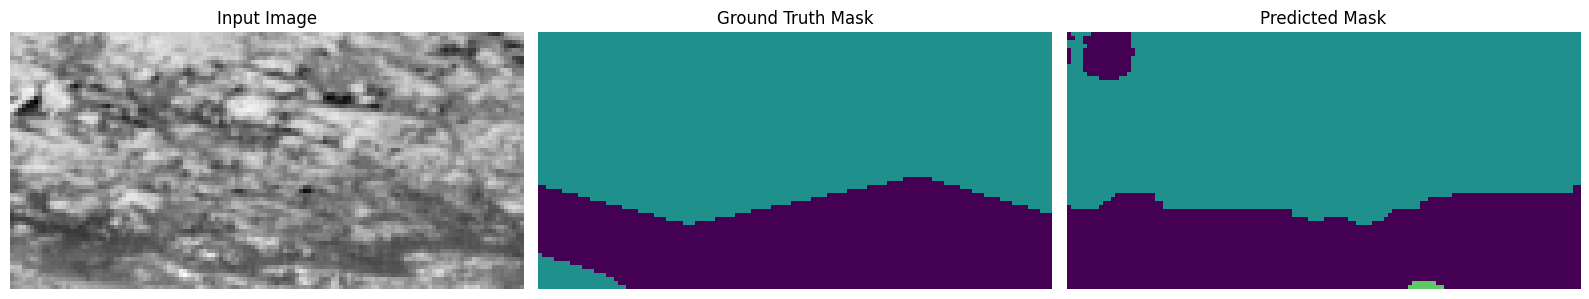

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.9435 - loss: 0.1534 - mean_iou: 0.6783 - val_accuracy: 0.7365 - val_loss: 0.8905 - val_mean_iou: 0.4176
Epoch 142/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9440 - loss: 0.1481 - mean_iou: 0.7051 - val_accuracy: 0.7540 - val_loss: 0.7998 - val_mean_iou: 0.4317
Epoch 143/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9501 - loss: 0.1350 - mean_iou: 0.6950 - val_accuracy: 0.7600 - val_loss: 0.8051 - val_mean_iou: 0.4369
Epoch 144/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9485 - loss: 0.1378 - mean_iou: 0.6953 - val_accuracy: 0.7421 - val_loss: 0.8173 - val_mean_iou: 0.4234
Epoch 145/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9501 - loss: 0.1336 - mean_iou: 0.7006 - val_accuracy: 0.7559 - val_loss: 0.8357 - val_mean_iou: 0.4424
Epoch 146/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9500 - loss: 0.1345 - mean_iou: 0.6934

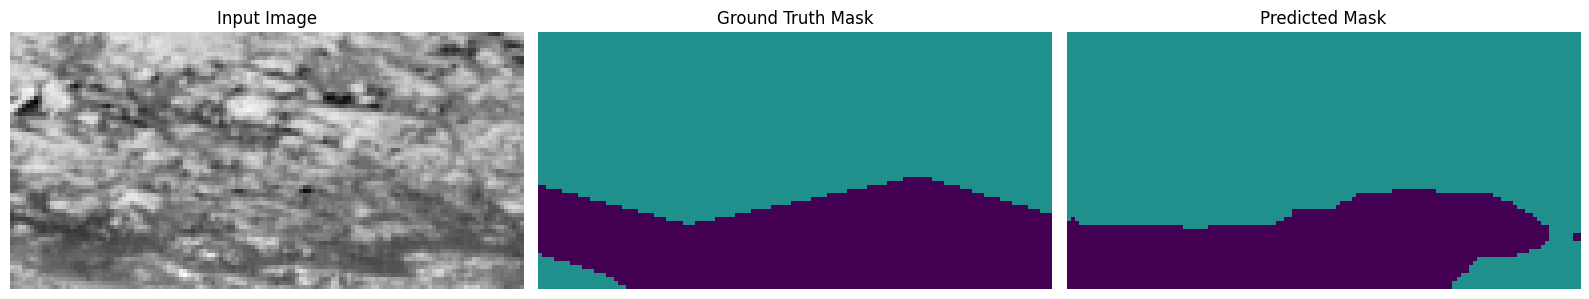

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 729ms/step - accuracy: 0.9500 - loss: 0.1345 - mean_iou: 0.6933 - val_accuracy: 0.7129 - val_loss: 0.8869 - val_mean_iou: 0.4063
Epoch 147/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9501 - loss: 0.1356 - mean_iou: 0.6937 - val_accuracy: 0.7352 - val_loss: 0.8303 - val_mean_iou: 0.4325
Epoch 148/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9531 - loss: 0.1268 - mean_iou: 0.7057 - val_accuracy: 0.7441 - val_loss: 0.7974 - val_mean_iou: 0.4537
Epoch 149/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9533 - loss: 0.1223 - mean_iou: 0.6883 - val_accuracy: 0.7166 - val_loss: 0.9768 - val_mean_iou: 0.4139
Epoch 150/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9534 - loss: 0.1247 - mean_iou: 0.7063 - val_accuracy: 0.7428 - val_loss: 0.8567 - val_mean_iou: 0.4259
Epoch 151/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9566 - loss: 0.1157 - mean_iou: 0.7117

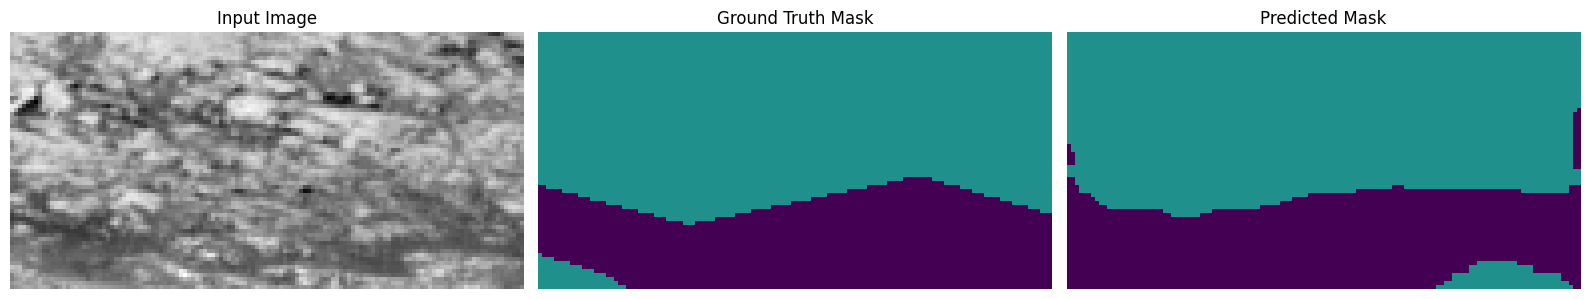

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 729ms/step - accuracy: 0.9565 - loss: 0.1157 - mean_iou: 0.7116 - val_accuracy: 0.7593 - val_loss: 0.7694 - val_mean_iou: 0.4453
Epoch 152/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.9576 - loss: 0.1123 - mean_iou: 0.7196 - val_accuracy: 0.7655 - val_loss: 0.8296 - val_mean_iou: 0.4652
Epoch 153/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9545 - loss: 0.1217 - mean_iou: 0.6911 - val_accuracy: 0.7372 - val_loss: 0.8763 - val_mean_iou: 0.4238
Epoch 154/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9474 - loss: 0.1419 - mean_iou: 0.7124 - val_accuracy: 0.7470 - val_loss: 0.8424 - val_mean_iou: 0.4338
Epoch 155/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.9539 - loss: 0.1248 - mean_iou: 0.6930 - val_accuracy: 0.7696 - val_loss: 0.8126 - val_mean_iou: 0.4618
Epoch 156/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9567 - loss: 0.1147 - mean_iou: 0.6871

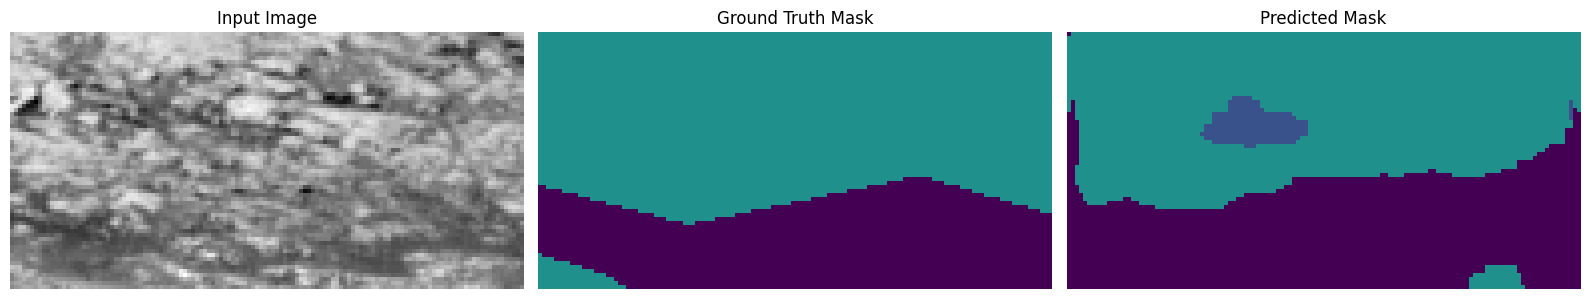

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9567 - loss: 0.1147 - mean_iou: 0.6874 - val_accuracy: 0.7376 - val_loss: 0.9205 - val_mean_iou: 0.4322
Epoch 157/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9546 - loss: 0.1212 - mean_iou: 0.7225 - val_accuracy: 0.7564 - val_loss: 0.8666 - val_mean_iou: 0.4578
Epoch 158/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.9587 - loss: 0.1108 - mean_iou: 0.7154 - val_accuracy: 0.7665 - val_loss: 0.7903 - val_mean_iou: 0.4500
Epoch 159/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9569 - loss: 0.1141 - mean_iou: 0.7038 - val_accuracy: 0.7309 - val_loss: 0.8544 - val_mean_iou: 0.4207
Epoch 160/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9569 - loss: 0.1140 - mean_iou: 0.6825 - val_accuracy: 0.7503 - val_loss: 0.8463 - val_mean_iou: 0.4324
Epoch 161/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9583 - loss: 0.1101 - mean_iou: 0.7137

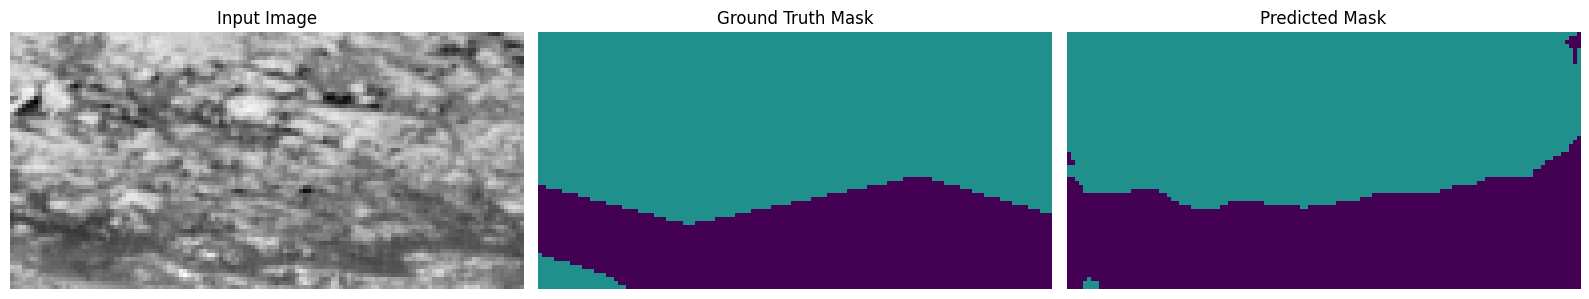

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9582 - loss: 0.1102 - mean_iou: 0.7132 - val_accuracy: 0.7517 - val_loss: 0.8357 - val_mean_iou: 0.4395
Epoch 162/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9568 - loss: 0.1181 - mean_iou: 0.7309 - val_accuracy: 0.6810 - val_loss: 1.1186 - val_mean_iou: 0.3562
Epoch 163/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9540 - loss: 0.1239 - mean_iou: 0.7223 - val_accuracy: 0.7624 - val_loss: 0.9142 - val_mean_iou: 0.4517
Epoch 164/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9601 - loss: 0.1057 - mean_iou: 0.7101 - val_accuracy: 0.7458 - val_loss: 0.9272 - val_mean_iou: 0.4304
Epoch 165/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9544 - loss: 0.1187 - mean_iou: 0.7139 - val_accuracy: 0.7547 - val_loss: 0.8775 - val_mean_iou: 0.4445
Epoch 166/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9566 - loss: 0.1149 - mean_iou: 0.7116

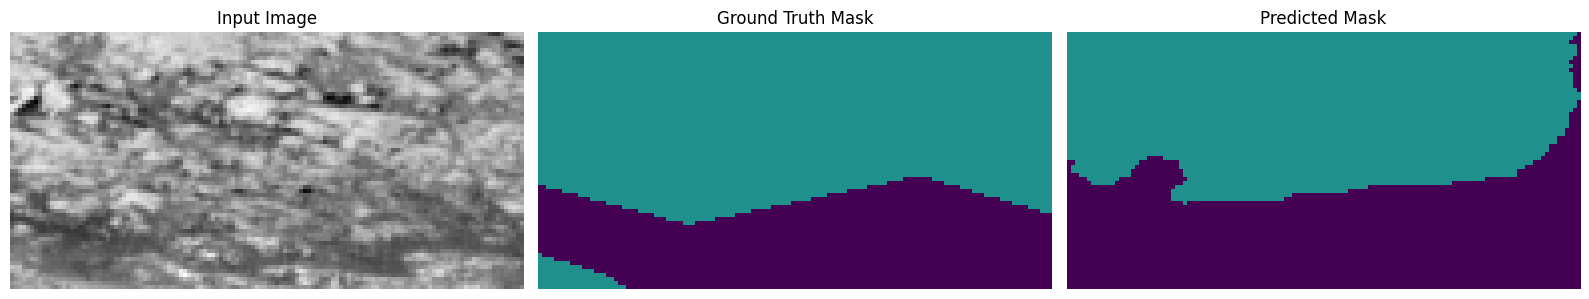

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9566 - loss: 0.1147 - mean_iou: 0.7118 - val_accuracy: 0.7222 - val_loss: 0.9550 - val_mean_iou: 0.4175
Epoch 167/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 713ms/step - accuracy: 0.9601 - loss: 0.1055 - mean_iou: 0.7208 - val_accuracy: 0.7623 - val_loss: 0.8187 - val_mean_iou: 0.4516
Epoch 168/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9605 - loss: 0.1041 - mean_iou: 0.7285 - val_accuracy: 0.7360 - val_loss: 0.9091 - val_mean_iou: 0.4183
Epoch 169/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.9600 - loss: 0.1048 - mean_iou: 0.7229 - val_accuracy: 0.7473 - val_loss: 0.9169 - val_mean_iou: 0.4244
Epoch 170/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.9605 - loss: 0.1051 - mean_iou: 0.7227 - val_accuracy: 0.7407 - val_loss: 0.8137 - val_mean_iou: 0.4481
Epoch 171/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9583 - loss: 0.1109 - mean_iou: 0.7181

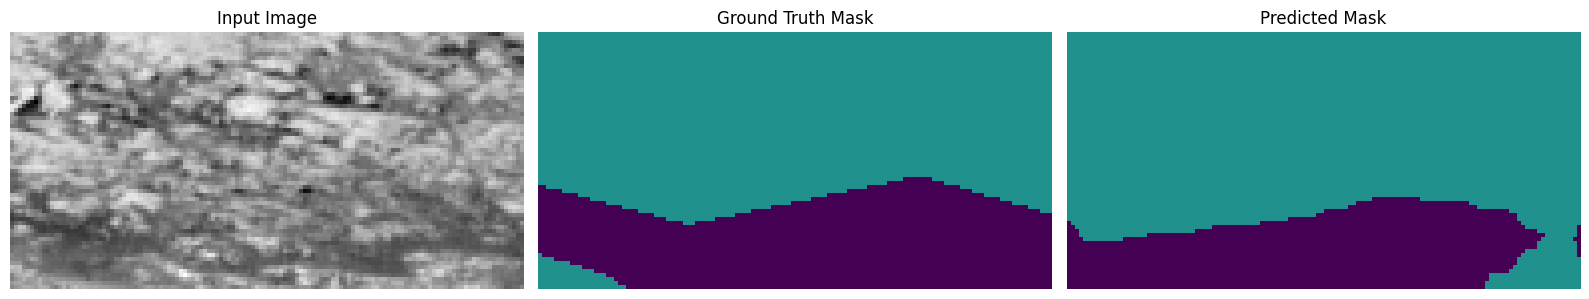

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9583 - loss: 0.1111 - mean_iou: 0.7178 - val_accuracy: 0.7406 - val_loss: 0.9985 - val_mean_iou: 0.4265
Epoch 172/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.9594 - loss: 0.1064 - mean_iou: 0.7096 - val_accuracy: 0.7467 - val_loss: 0.8394 - val_mean_iou: 0.4403
Epoch 173/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9534 - loss: 0.1337 - mean_iou: 0.7047 - val_accuracy: 0.7112 - val_loss: 1.1677 - val_mean_iou: 0.3960
Epoch 174/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9465 - loss: 0.1450 - mean_iou: 0.6953 - val_accuracy: 0.7161 - val_loss: 1.1543 - val_mean_iou: 0.3985
Epoch 175/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9498 - loss: 0.1365 - mean_iou: 0.7200 - val_accuracy: 0.7475 - val_loss: 1.1874 - val_mean_iou: 0.4382
Epoch 176/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9556 - loss: 0.1181 - mean_iou: 0.7203

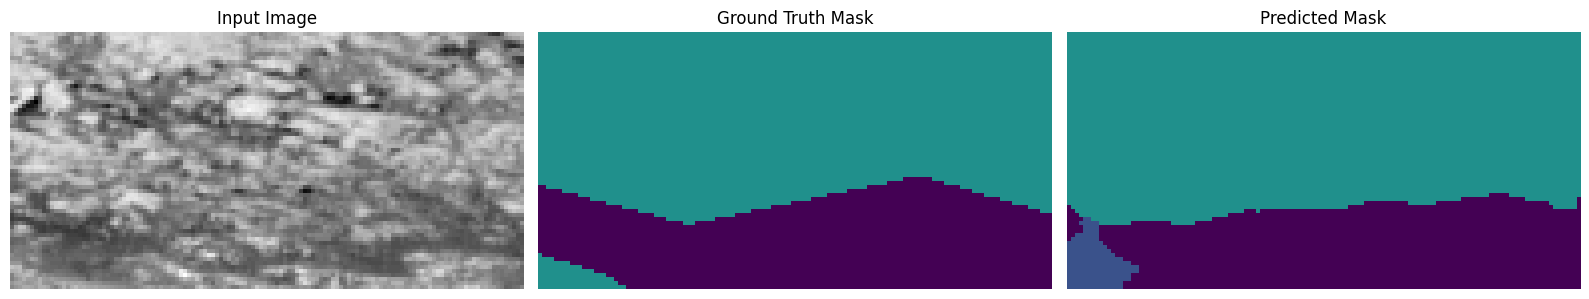

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.9556 - loss: 0.1181 - mean_iou: 0.7204 - val_accuracy: 0.7558 - val_loss: 1.0420 - val_mean_iou: 0.4619
Epoch 177/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9554 - loss: 0.1180 - mean_iou: 0.6989 - val_accuracy: 0.6585 - val_loss: 1.3619 - val_mean_iou: 0.3435
Epoch 178/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.9589 - loss: 0.1073 - mean_iou: 0.6986 - val_accuracy: 0.6859 - val_loss: 1.2126 - val_mean_iou: 0.3694
Epoch 179/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9601 - loss: 0.1054 - mean_iou: 0.7118 - val_accuracy: 0.7079 - val_loss: 1.2398 - val_mean_iou: 0.3871
Epoch 180/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.9594 - loss: 0.1089 - mean_iou: 0.7074 - val_accuracy: 0.7581 - val_loss: 0.8975 - val_mean_iou: 0.4471
Epoch 181/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9607 - loss: 0.1031 - mean_iou: 0.7161

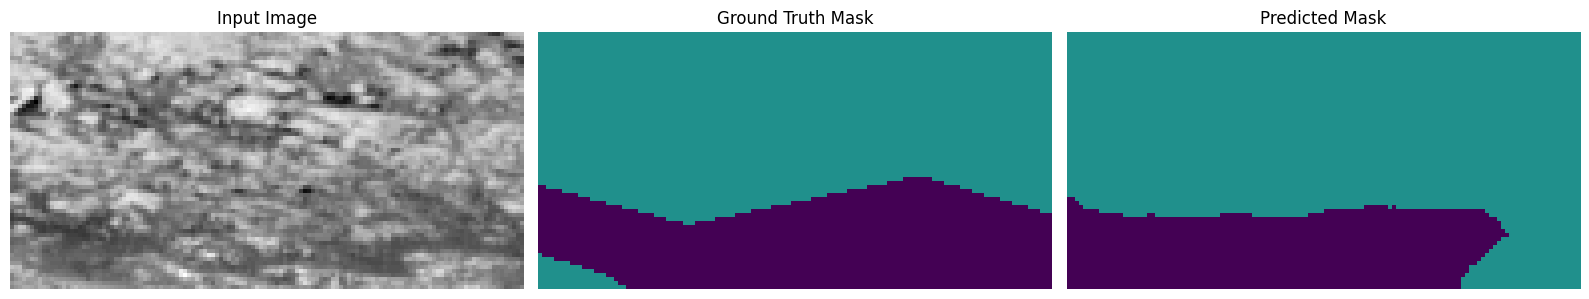

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.9607 - loss: 0.1030 - mean_iou: 0.7164 - val_accuracy: 0.7295 - val_loss: 1.0135 - val_mean_iou: 0.4115
Epoch 182/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9573 - loss: 0.1156 - mean_iou: 0.7091 - val_accuracy: 0.7198 - val_loss: 0.9438 - val_mean_iou: 0.4052
Epoch 183/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.9605 - loss: 0.1044 - mean_iou: 0.7038 - val_accuracy: 0.7385 - val_loss: 0.9321 - val_mean_iou: 0.4249
Epoch 184/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9613 - loss: 0.1016 - mean_iou: 0.7262 - val_accuracy: 0.7275 - val_loss: 1.0168 - val_mean_iou: 0.4098
Epoch 185/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.9521 - loss: 0.1283 - mean_iou: 0.7203 - val_accuracy: 0.7235 - val_loss: 1.0867 - val_mean_iou: 0.4053
Epoch 186/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9569 - loss: 0.1154 - mean_iou: 0.7243

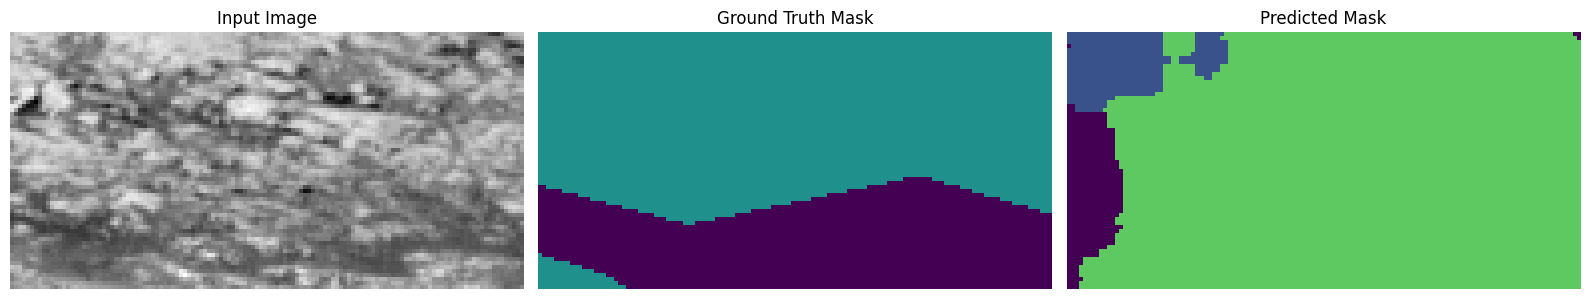

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.9568 - loss: 0.1156 - mean_iou: 0.7239 - val_accuracy: 0.6384 - val_loss: 1.3958 - val_mean_iou: 0.3173
Epoch 187/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.9533 - loss: 0.1260 - mean_iou: 0.7216 - val_accuracy: 0.7057 - val_loss: 1.2742 - val_mean_iou: 0.3970
Epoch 188/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - accuracy: 0.9431 - loss: 0.1533 - mean_iou: 0.7025 - val_accuracy: 0.7430 - val_loss: 1.0137 - val_mean_iou: 0.4374
Epoch 189/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step - accuracy: 0.9520 - loss: 0.1293 - mean_iou: 0.7055 - val_accuracy: 0.6933 - val_loss: 1.3399 - val_mean_iou: 0.3881
Epoch 190/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.9522 - loss: 0.1293 - mean_iou: 0.7178 - val_accuracy: 0.7406 - val_loss: 0.9989 - val_mean_iou: 0.4346
Epoch 191/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9600 - loss: 0.1048 - mean_iou: 0.7341

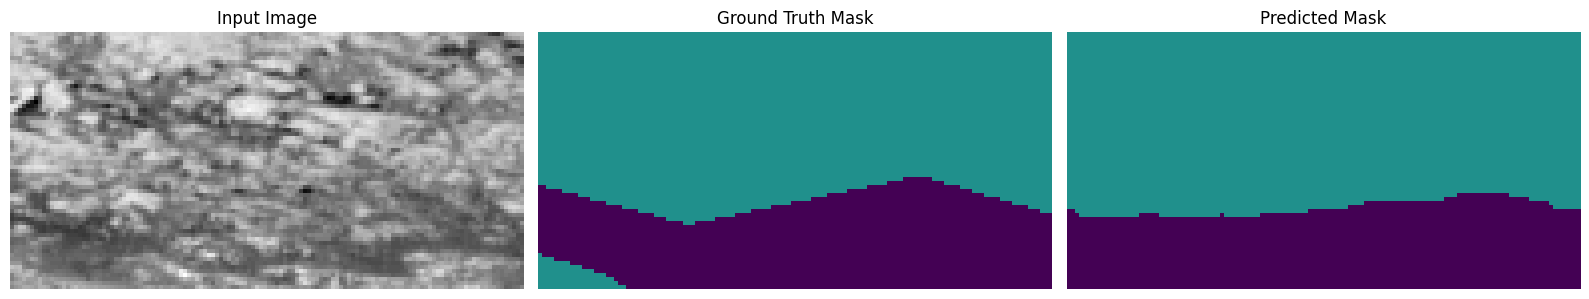

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.9601 - loss: 0.1048 - mean_iou: 0.7336 - val_accuracy: 0.7624 - val_loss: 0.9791 - val_mean_iou: 0.4550
Epoch 192/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 709ms/step - accuracy: 0.9619 - loss: 0.0986 - mean_iou: 0.7297 - val_accuracy: 0.6236 - val_loss: 1.4191 - val_mean_iou: 0.3151
Epoch 193/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.9618 - loss: 0.1015 - mean_iou: 0.7298 - val_accuracy: 0.7479 - val_loss: 0.9397 - val_mean_iou: 0.4357
Epoch 194/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9659 - loss: 0.0890 - mean_iou: 0.7307 - val_accuracy: 0.7547 - val_loss: 0.8843 - val_mean_iou: 0.4354
Epoch 195/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 713ms/step - accuracy: 0.9662 - loss: 0.0873 - mean_iou: 0.6981 - val_accuracy: 0.7419 - val_loss: 0.9138 - val_mean_iou: 0.4232
Epoch 196/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9654 - loss: 0.0908 - mean_iou: 0.7289

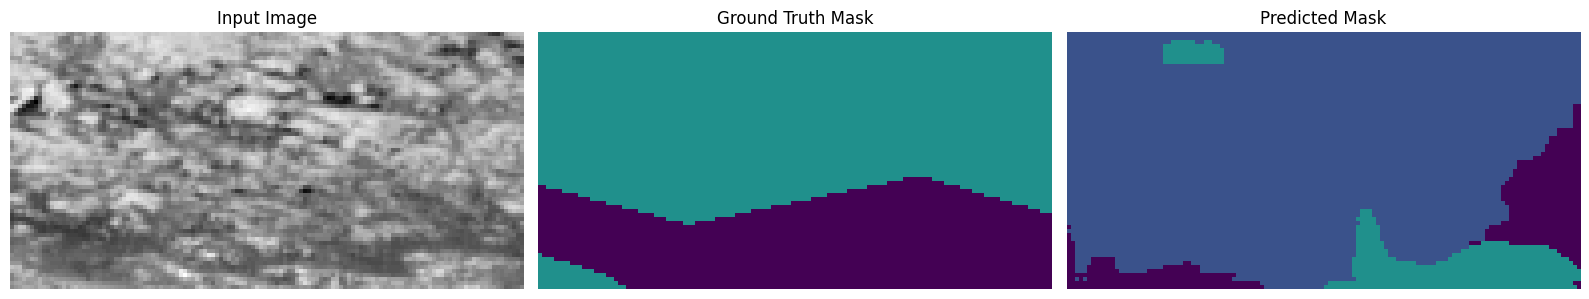

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.9653 - loss: 0.0911 - mean_iou: 0.7286 - val_accuracy: 0.7020 - val_loss: 1.1243 - val_mean_iou: 0.3845
Epoch 197/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9568 - loss: 0.1140 - mean_iou: 0.7211 - val_accuracy: 0.6490 - val_loss: 1.3278 - val_mean_iou: 0.3329
Epoch 198/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.9576 - loss: 0.1135 - mean_iou: 0.7138 - val_accuracy: 0.7347 - val_loss: 1.0748 - val_mean_iou: 0.4272
Epoch 199/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.9482 - loss: 0.1353 - mean_iou: 0.7087 - val_accuracy: 0.6485 - val_loss: 1.4952 - val_mean_iou: 0.3334
Epoch 200/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9540 - loss: 0.1200 - mean_iou: 0.6953 - val_accuracy: 0.7431 - val_loss: 1.0614 - val_mean_iou: 0.4266
Epoch 201/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9623 - loss: 0.0993 - mean_iou: 0.7193

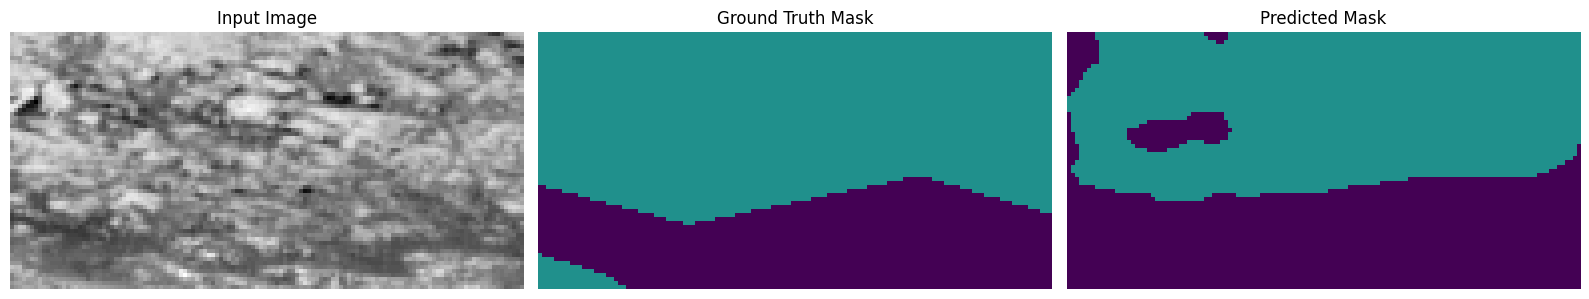

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9623 - loss: 0.0993 - mean_iou: 0.7195 - val_accuracy: 0.7085 - val_loss: 1.0937 - val_mean_iou: 0.3872
Epoch 202/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 717ms/step - accuracy: 0.9609 - loss: 0.1051 - mean_iou: 0.7300 - val_accuracy: 0.7348 - val_loss: 0.9288 - val_mean_iou: 0.4222
Final validation Mean Intersection Over Union: 46.52%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

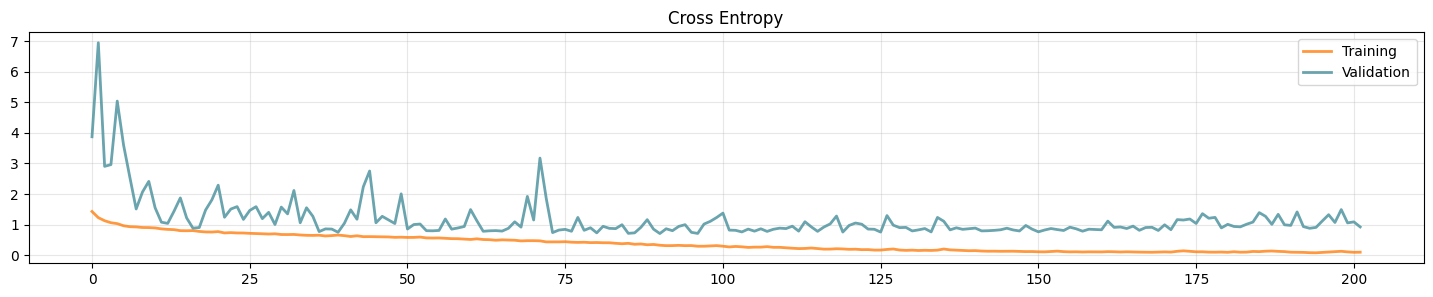

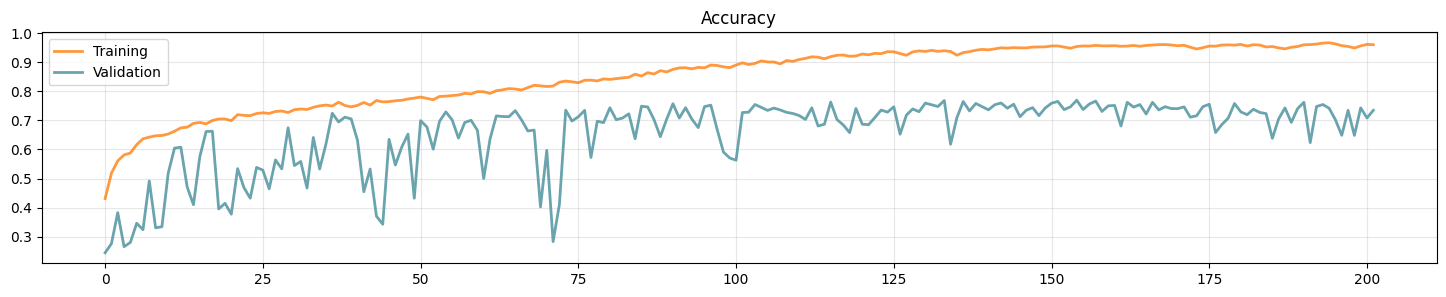

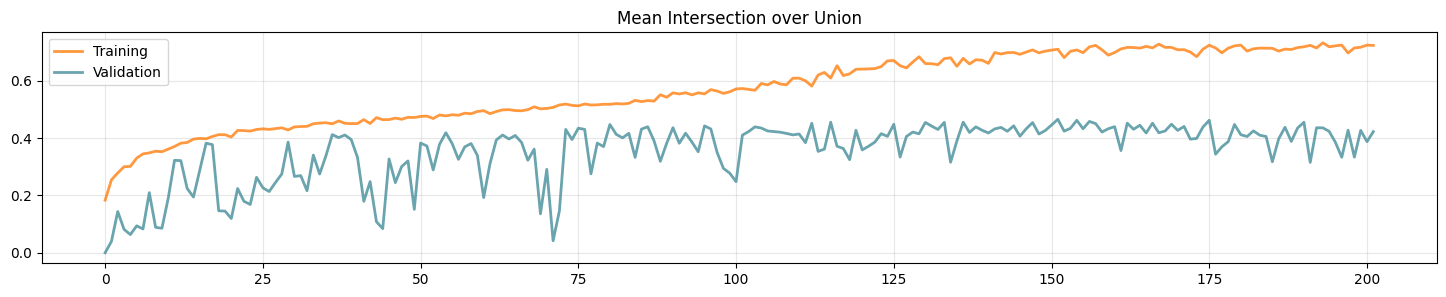

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
# if "model_filename" not in globals() or model_filename is None:
#     files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#     files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#     if files:
#         model_filename = files[0]
#     else:
#         raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
# model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_UNet_46.52.keras


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 771ms/step
Predictions shape: (300, 64, 128)


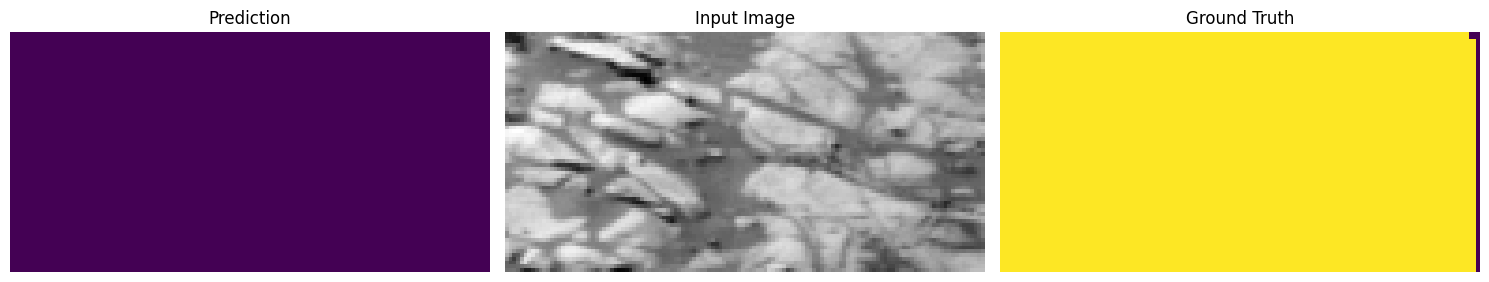

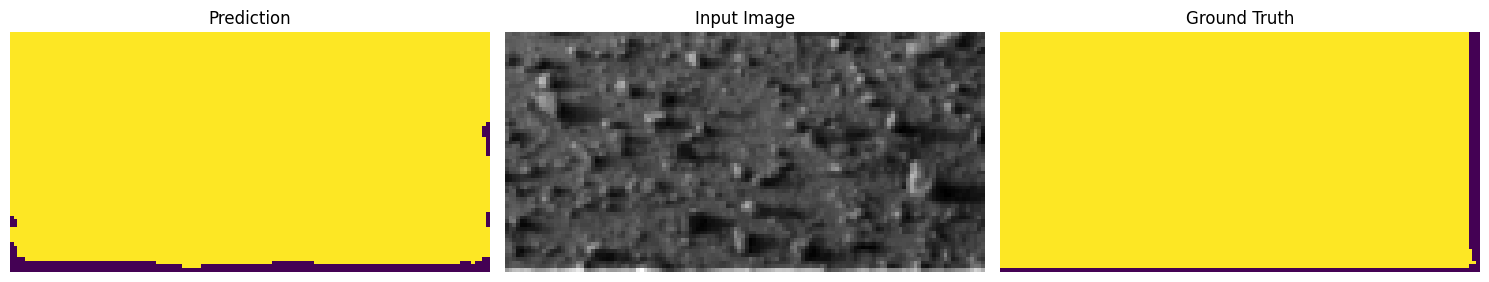

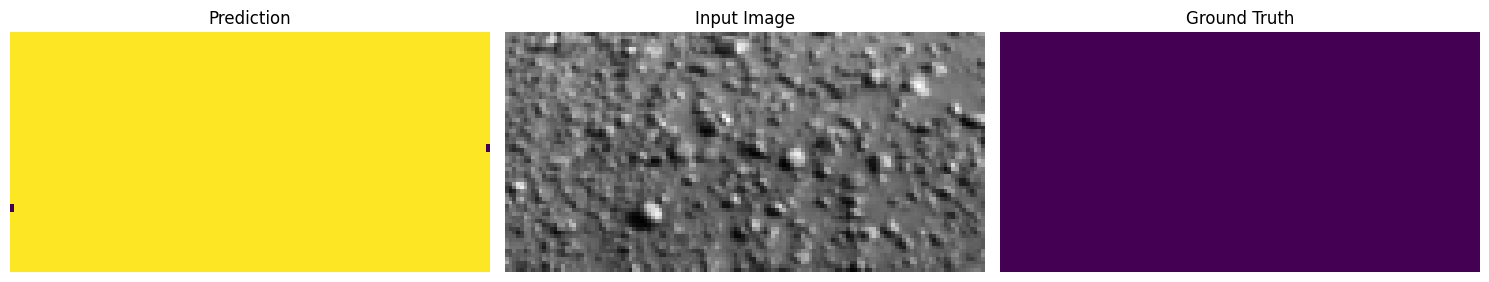

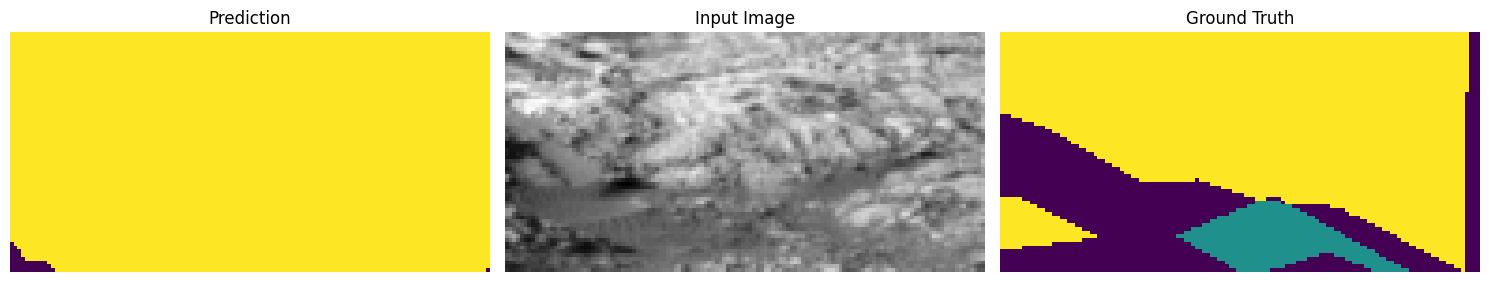

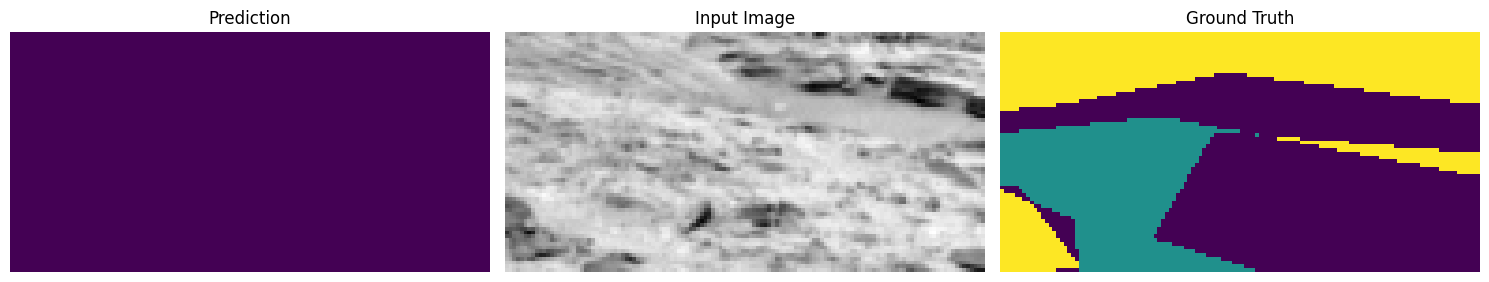

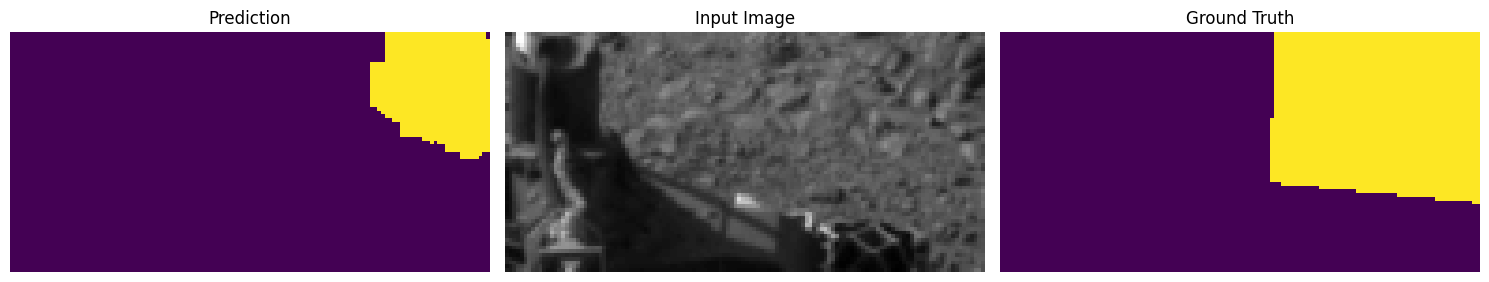

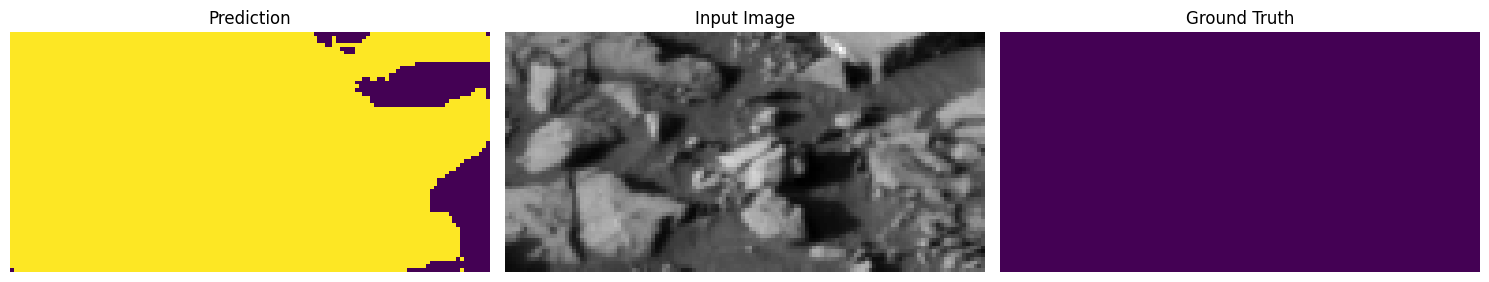

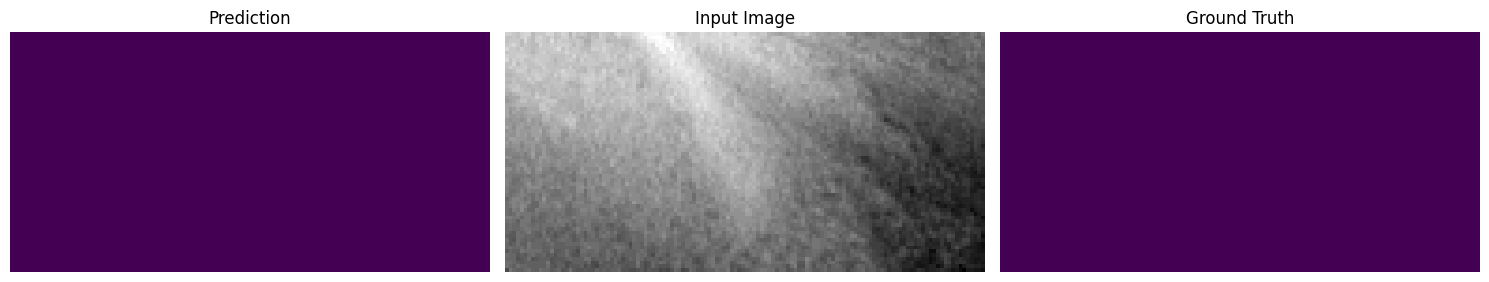

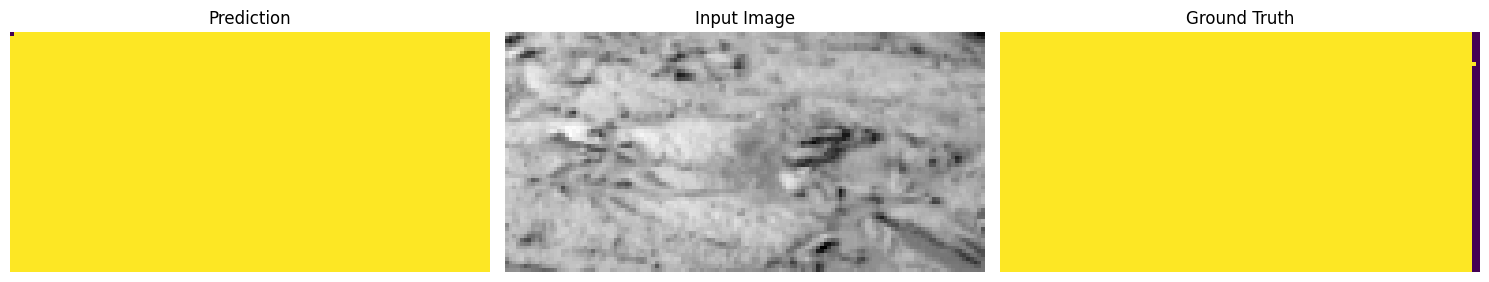

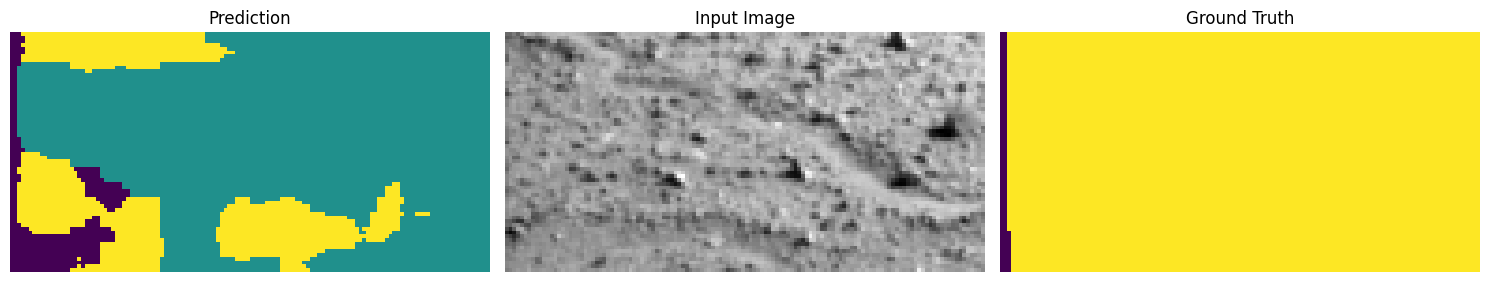

In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(test_lbl[i])
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step
(10022, 64, 128)


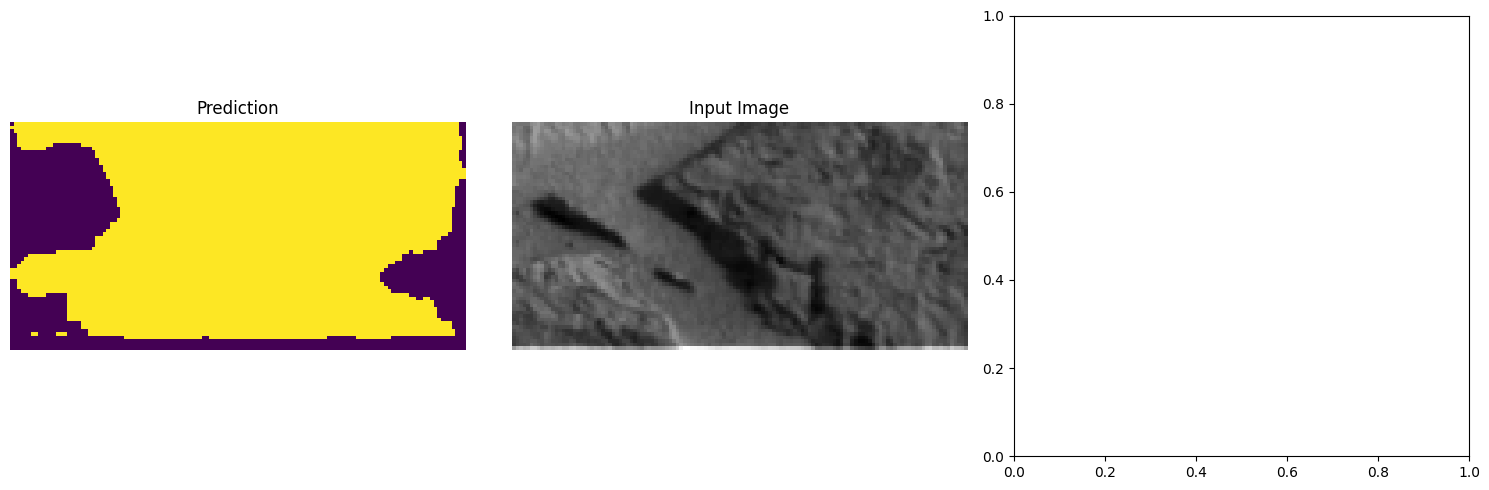

(10022, 64, 128)


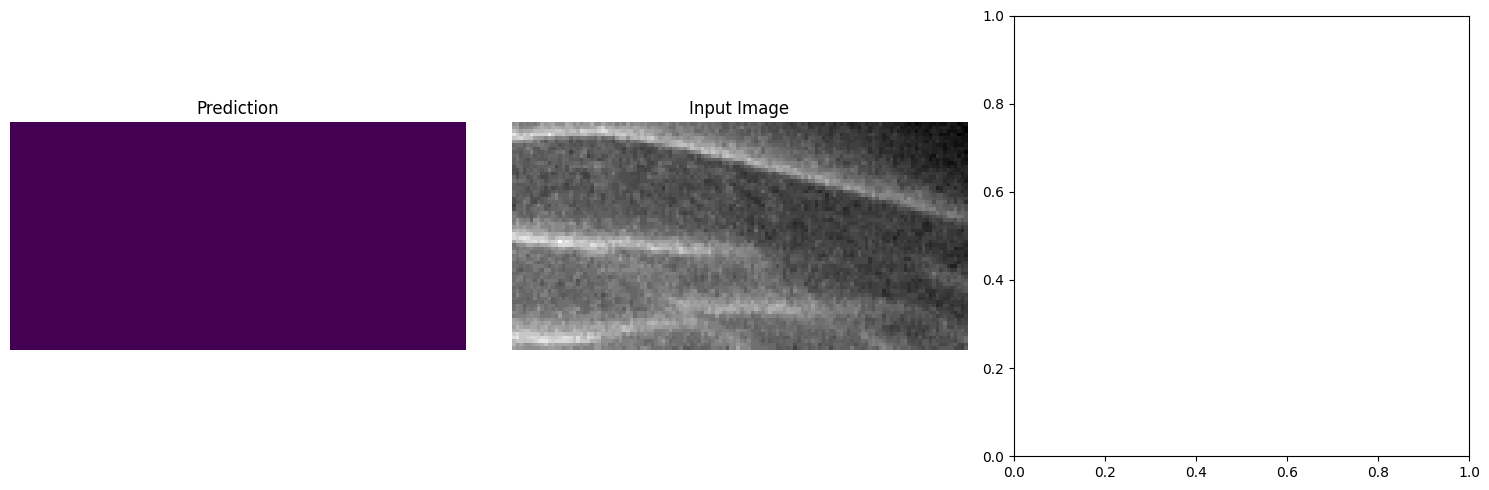

(10022, 64, 128)


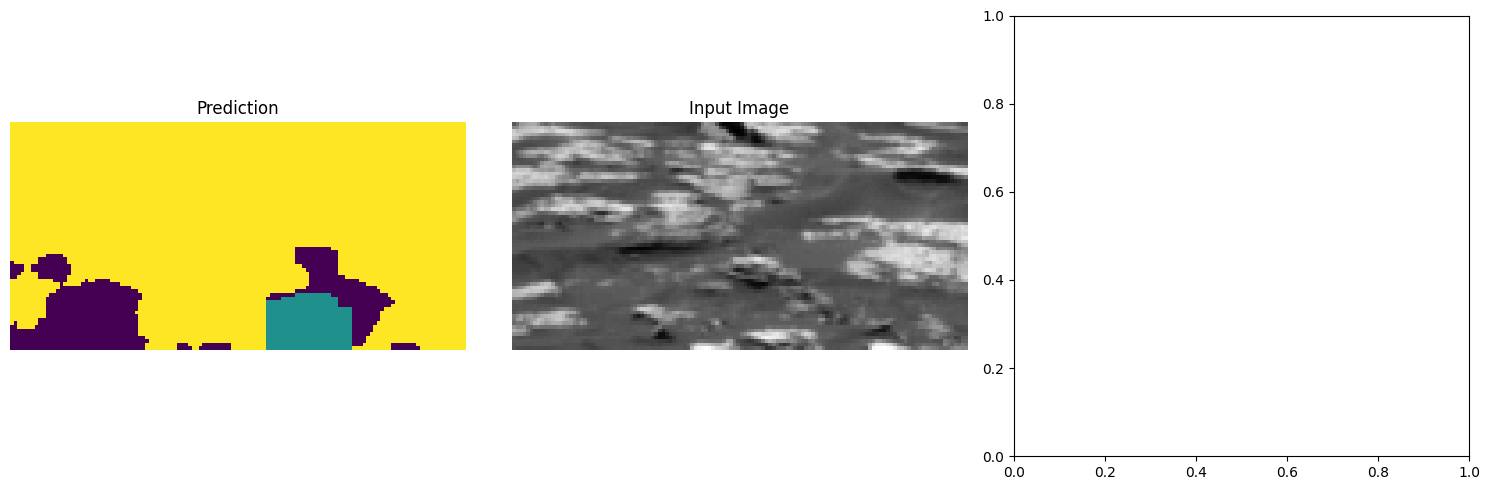

(10022, 64, 128)


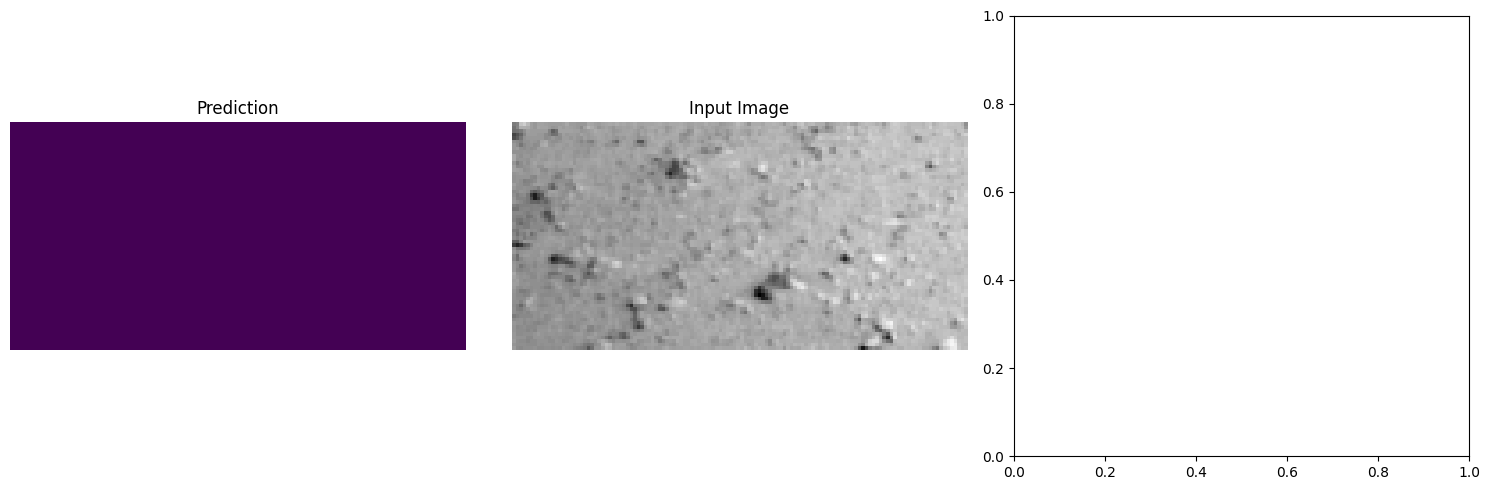

(10022, 64, 128)


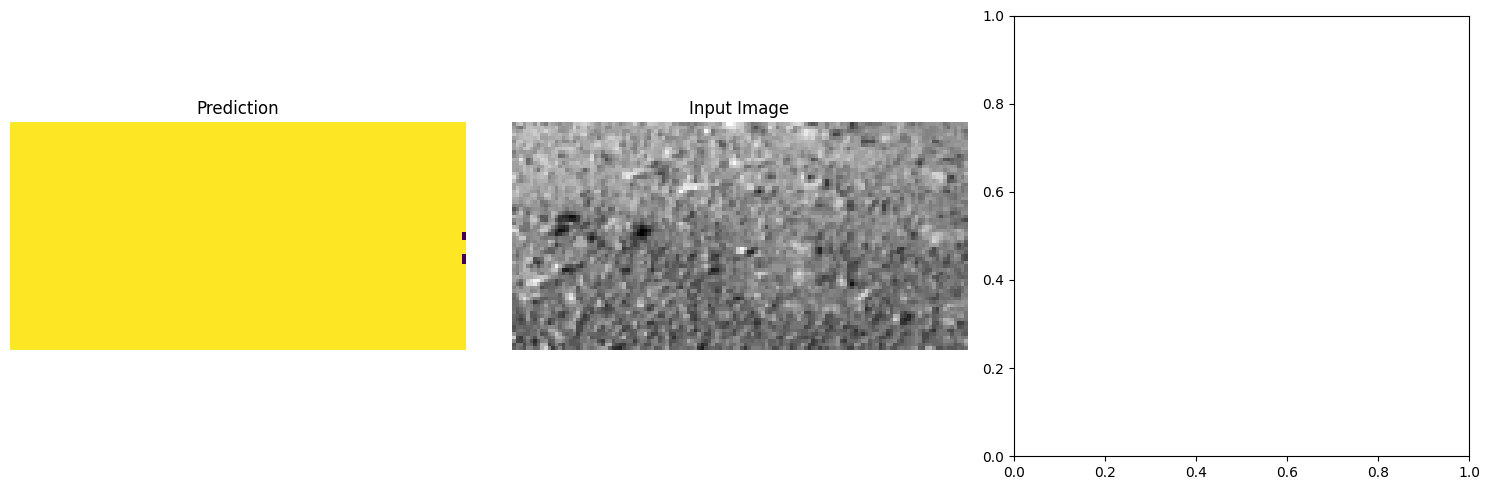

(10022, 64, 128)


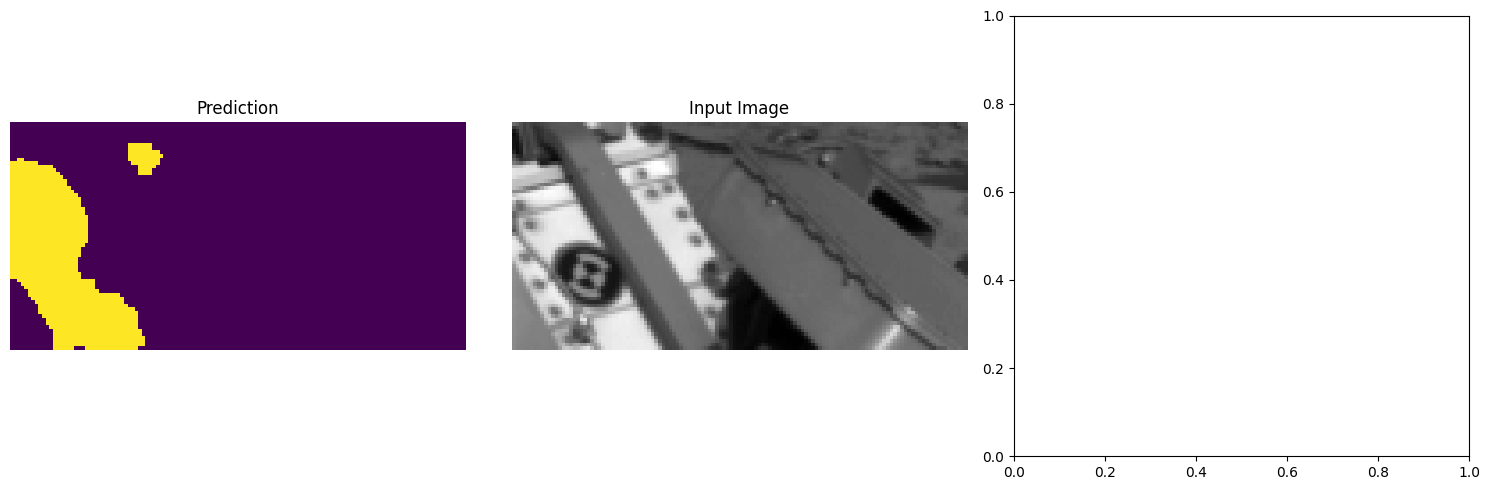

(10022, 64, 128)


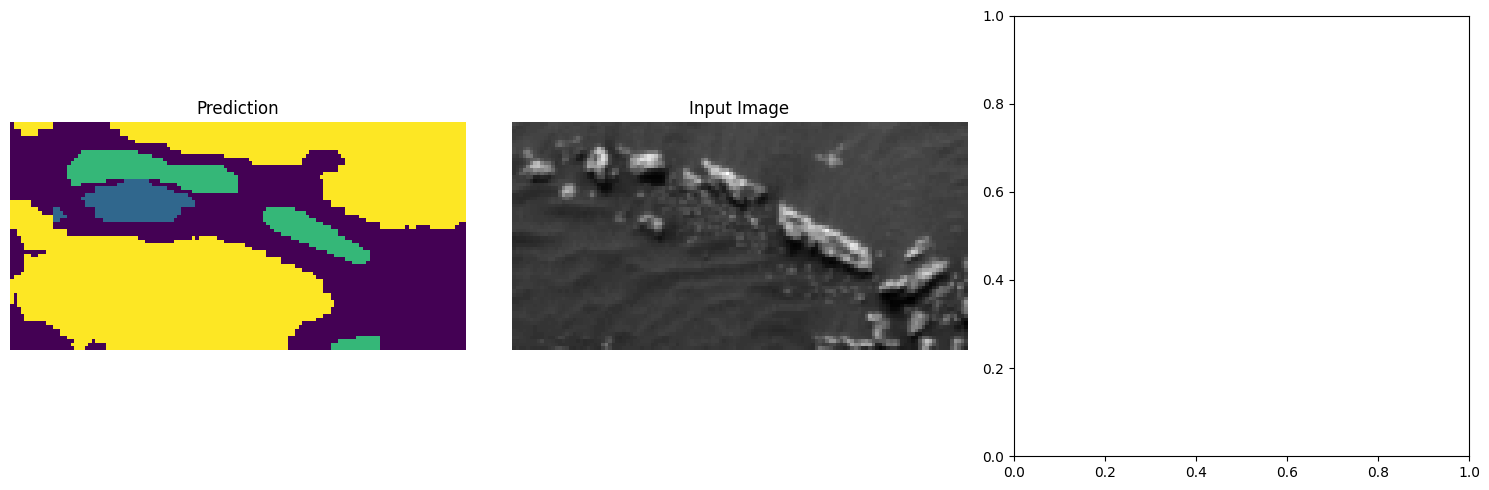

(10022, 64, 128)


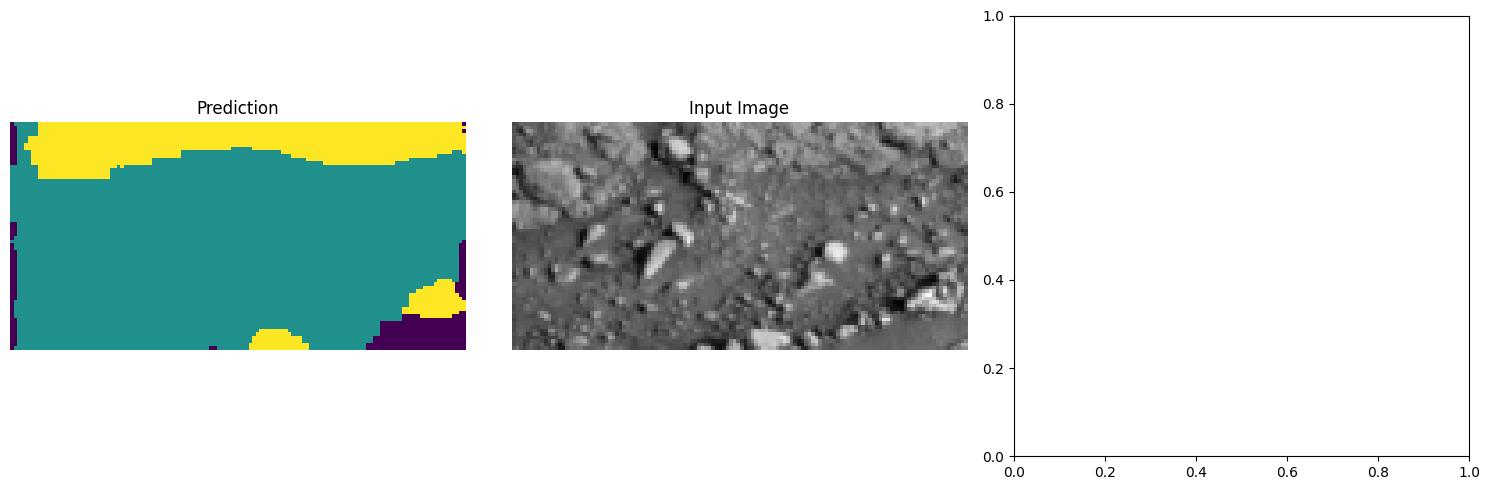

(10022, 64, 128)


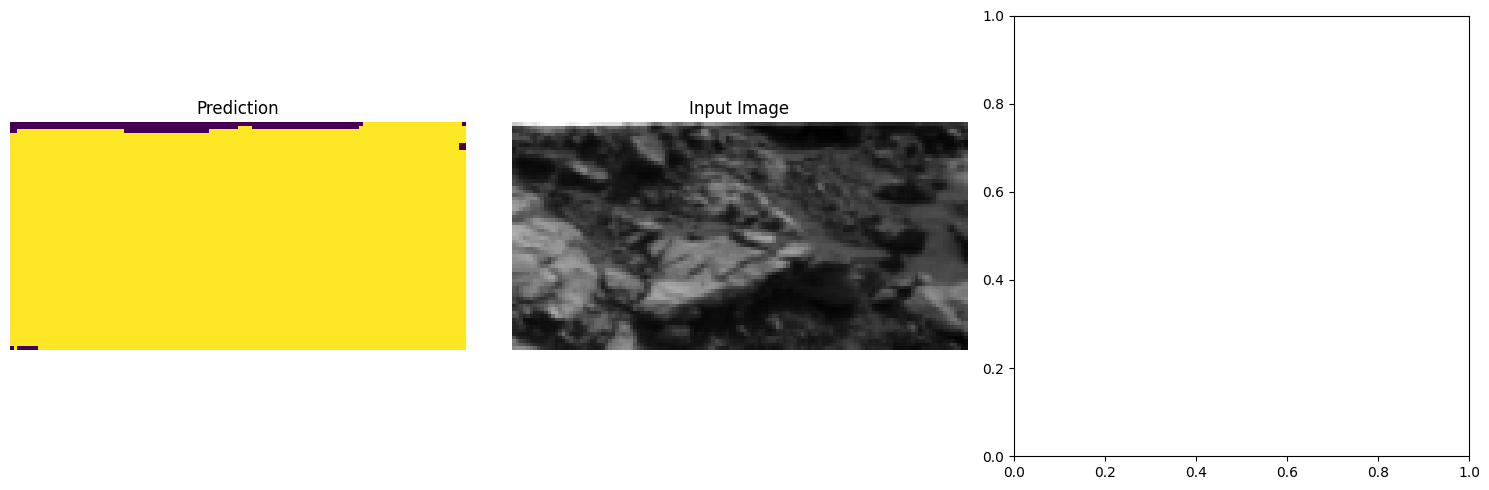

(10022, 64, 128)


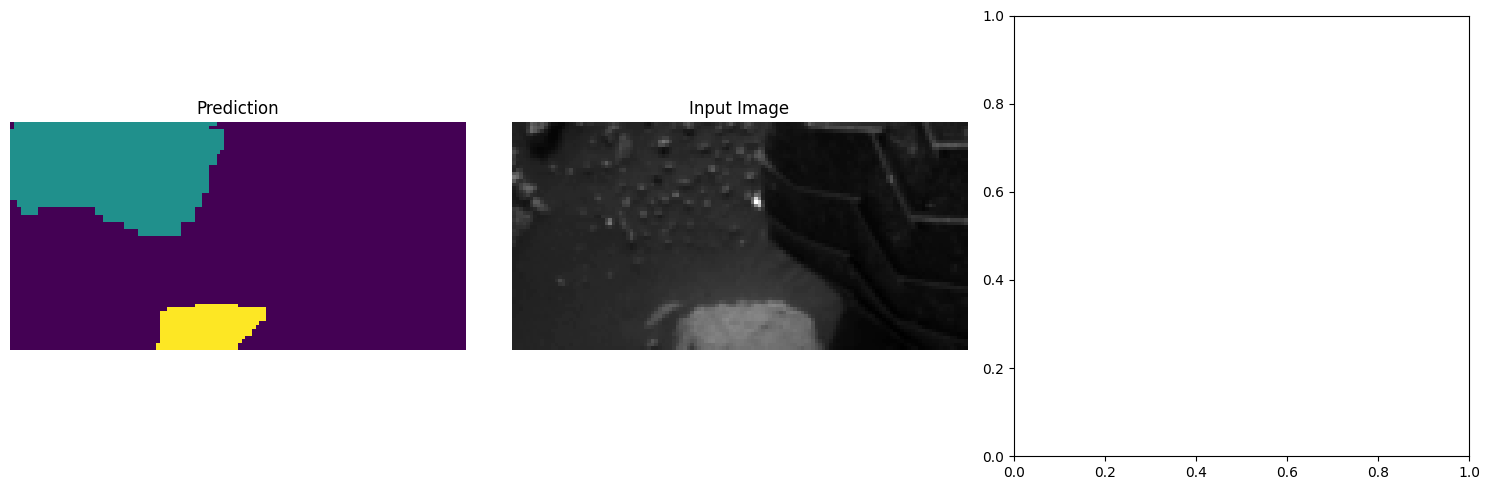

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  print(preds.shape)
  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [46]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(submission_filename)
from google.colab import files
files.download(submission_filename)

submission_UNet_46.52.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```